In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.multioutput import MultiOutputRegressor
from time import time
from time import sleep
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor #predecir
#from sklearn.externals import joblib #para guardar la red entrenada
import joblib

#Nuevos Datos

In [ ]:
#cargar datos Plugs
csv = '/content/drive/MyDrive/LosSantos/plugsLosSantos.csv'
df = pd.read_csv(csv, delimiter=';', decimal='.')
plugs = df.copy()
plugs.head()

Muestra Estacion MuestraNew           X           Y       Z  \
0   Ls5-12   LSN-01     LSN-01  1114949.39  1246238.02  1745.0   
1  Ls5-13a   LSN-02    LSN-02a  1115819.32  1247030.08  1761.0   
2  Ls5-13b   LSN-02    LSN-02b  1115819.32  1247030.08  1761.0   
3   Ls6-01   LSN-03     LSN-03  1115324.37  1256812.13  1677.0   
4   Ls6-02   LSN-04     LSN-04  1115076.27  1257212.30  1608.0   

  Formacion Geologica   Unidad Litologia Abreviacion  ... M Dry [mV/V]  \
0      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...         8.65   
1      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...         9.65   
2      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...         9.83   
3      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...        47.46   
4      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...         9.74   

   M Wet [mV/V]  Vp [m/s]  Peak Load [kN]  Is50 [MPa]   LF [SI]   HF [SI]  \
0         22.49    1059.0            1.32        0.41  0.000015  0.000024   
1         21.16    1294.0            1.82        0.61  0.000008  0.000003   
2         14.52    2550.0            0.52        0.33  0.000021  0.000032   
3          7.52    3297.0            0.72        0.24  0.000003  0.000002   
4         33.65    2175.0            0.42        0.13  0.000021  0.000036   

   FD [%]  Distancia Falla [m]  Unnamed: 25  
0  -61.45              1579.23          NaN  
1   59.76               577.10          NaN  
2  -49.71               577.10          NaN  
3   50.98                21.24          NaN  
4  -69.97               211.66          NaN  

[5 rows x 26 columns]

##reemplazar unidades a numeros

In [ ]:
#reemplazar la undiad por su numero
plugs['GeoNN'] = plugs['Unidad'].replace({'K1t':8,
                                          'K1p':7,
                                          'K1r':6,
                                          'K1ls_ms':5,
                                          'K1ls_mm':4,
                                          'K1ls_mi':3,
                                          'J1-2j':2,
                                          'J1gp':1,
                                          'Oss':0})
plugs.head()

Muestra Estacion MuestraNew           X           Y       Z  \
0   Ls5-12   LSN-01     LSN-01  1114949.39  1246238.02  1745.0   
1  Ls5-13a   LSN-02    LSN-02a  1115819.32  1247030.08  1761.0   
2  Ls5-13b   LSN-02    LSN-02b  1115819.32  1247030.08  1761.0   
3   Ls6-01   LSN-03     LSN-03  1115324.37  1256812.13  1677.0   
4   Ls6-02   LSN-04     LSN-04  1115076.27  1257212.30  1608.0   

  Formacion Geologica   Unidad Litologia Abreviacion  ... M Wet [mV/V]  \
0      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...        22.49   
1      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...        21.16   
2      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...        14.52   
3      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...         7.52   
4      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...        33.65   

   Vp [m/s]  Peak Load [kN]  Is50 [MPa]   LF [SI]   HF [SI]  FD [%]  \
0    1059.0            1.32        0.41  0.000015  0.000024  -61.45   
1    1294.0            1.82        0.61  0.000008  0.000003   59.76   
2    2550.0            0.52        0.33  0.000021  0.000032  -49.71   
3    3297.0            0.72        0.24  0.000003  0.000002   50.98   
4    2175.0            0.42        0.13  0.000021  0.000036  -69.97   

   Distancia Falla [m]  Unnamed: 25  GeoNN  
0              1579.23          NaN      5  
1               577.10          NaN      5  
2               577.10          NaN      5  
3                21.24          NaN      5  
4               211.66          NaN      5  

[5 rows x 27 columns]

##normalizar entradas

In [ ]:
plugs.columns

Index(['Muestra', 'Estacion', 'MuestraNew', 'X', 'Y', 'Z',
       'Formacion Geologica', 'Unidad', 'Litologia', 'Abreviacion', 'Uni-Lito',
       'Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]', 'Rho Dry [Ohm*m]',
       'Rho Wet [Ohm*m]', 'M Dry [mV/V]', 'M Wet [mV/V]', 'Vp [m/s]',
       'Peak Load [kN]', 'Is50 [MPa]', 'LF [SI]', 'HF [SI]', 'FD [%]',
       'Distancia Falla [m]', 'Unnamed: 25', 'GeoNN'],
      dtype='object')

In [ ]:
#se normalizan los valores de entrada
#rango para normalizar :
#Z -150 - 1830
#X 1096700 - 1120100
#Y 1235500 - 1260100
#DF 000 - 3000
plugs['Xn'] = (plugs['X'] - 1096700) / (1120100 - 1096700)
plugs['Yn'] = (plugs['Y'] - 1235500) / (1260100 - 1235500)
plugs['Zn'] = (plugs['Z'] - (-150)) / (1830 - (-150))
plugs['DFn'] = (plugs['Distancia Falla [m]'] - (000)) / (3000 - (000))


plugs.head()

Muestra Estacion MuestraNew           X           Y       Z  \
0   Ls5-12   LSN-01     LSN-01  1114949.39  1246238.02  1745.0   
1  Ls5-13a   LSN-02    LSN-02a  1115819.32  1247030.08  1761.0   
2  Ls5-13b   LSN-02    LSN-02b  1115819.32  1247030.08  1761.0   
3   Ls6-01   LSN-03     LSN-03  1115324.37  1256812.13  1677.0   
4   Ls6-02   LSN-04     LSN-04  1115076.27  1257212.30  1608.0   

  Formacion Geologica   Unidad Litologia Abreviacion  ...   LF [SI]   HF [SI]  \
0      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...  0.000015  0.000024   
1      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...  0.000008  0.000003   
2      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...  0.000021  0.000032   
3      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...  0.000003  0.000002   
4      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...  0.000021  0.000036   

   FD [%]  Distancia Falla [m]  Unnamed: 25  GeoNN        Xn        Yn  \
0  -61.45              1579.23          NaN      5  0.779888  0.436505   
1   59.76               577.10          NaN      5  0.817065  0.468702   
2  -49.71               577.10          NaN      5  0.817065  0.468702   
3   50.98                21.24          NaN      5  0.795913  0.866347   
4  -69.97               211.66          NaN      5  0.785311  0.882614   

         Zn       DFn  
0  0.957071  0.526410  
1  0.965152  0.192367  
2  0.965152  0.192367  
3  0.922727  0.007080  
4  0.887879  0.070553  

[5 rows x 31 columns]

## Log10

In [ ]:
plugs.columns

Index(['Muestra', 'Estacion', 'MuestraNew', 'X', 'Y', 'Z',
       'Formacion Geologica', 'Unidad', 'Litologia', 'Abreviacion', 'Uni-Lito',
       'Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]', 'Rho Dry [Ohm*m]',
       'Rho Wet [Ohm*m]', 'M Dry [mV/V]', 'M Wet [mV/V]', 'Vp [m/s]',
       'Peak Load [kN]', 'Is50 [MPa]', 'LF [SI]', 'HF [SI]', 'FD [%]',
       'Distancia Falla [m]', 'Unnamed: 25', 'GeoNN', 'Xn', 'Yn', 'Zn', 'DFn'],
      dtype='object')

In [ ]:
#se calcula el log10 de algunas columnas con numeros muy grandes
plugs['Log10 Rho Dry [Ohm*m]'] = np.log10(plugs['Rho Dry [Ohm*m]'])
plugs['Log10 Rho Wet [Ohm*m]'] = np.log10(plugs['Rho Wet [Ohm*m]'])
plugs['Log10 Vp [m/s]'] = np.log10(plugs['Vp [m/s]'])
plugs['Log10 LF [SI]'] = np.log10(plugs['LF [SI]'])
plugs['Log10 HF [SI]'] = np.log10(plugs['HF [SI]'])


plugs.head()

Muestra Estacion MuestraNew           X           Y       Z  \
0   Ls5-12   LSN-01     LSN-01  1114949.39  1246238.02  1745.0   
1  Ls5-13a   LSN-02    LSN-02a  1115819.32  1247030.08  1761.0   
2  Ls5-13b   LSN-02    LSN-02b  1115819.32  1247030.08  1761.0   
3   Ls6-01   LSN-03     LSN-03  1115324.37  1256812.13  1677.0   
4   Ls6-02   LSN-04     LSN-04  1115076.27  1257212.30  1608.0   

  Formacion Geologica   Unidad Litologia Abreviacion  ... GeoNN        Xn  \
0      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...     5  0.779888   
1      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...     5  0.817065   
2      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...     5  0.817065   
3      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...     5  0.795913   
4      Fm. Los Santos  K1ls_ms  arenisca          Ar  ...     5  0.785311   

         Yn        Zn       DFn  Log10 Rho Dry [Ohm*m]  Log10 Rho Wet [Ohm*m]  \
0  0.436505  0.957071  0.526410               4.909057               2.962128   
1  0.468702  0.965152  0.192367               4.444678               2.912158   
2  0.468702  0.965152  0.192367               4.272510               2.498917   
3  0.866347  0.922727  0.007080               6.204338               2.697186   
4  0.882614  0.887879  0.070553               4.147069               2.821015   

   Log10 Vp [m/s]  Log10 LF [SI]  Log10 HF [SI]  
0        3.024896      -4.832683      -4.623423  
1        3.111934      -5.123782      -5.518557  
2        3.406540      -4.673664      -4.497573  
3        3.518119      -5.469800      -5.779892  
4        3.337459      -4.669586      -4.438899  

[5 rows x 36 columns]

##Datos X y Y

In [ ]:
plugs.columns

Index(['Muestra', 'Estacion', 'MuestraNew', 'X', 'Y', 'Z',
       'Formacion Geologica', 'Unidad', 'Litologia', 'Abreviacion', 'Uni-Lito',
       'Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]', 'Rho Dry [Ohm*m]',
       'Rho Wet [Ohm*m]', 'M Dry [mV/V]', 'M Wet [mV/V]', 'Vp [m/s]',
       'Peak Load [kN]', 'Is50 [MPa]', 'LF [SI]', 'HF [SI]', 'FD [%]',
       'Distancia Falla [m]', 'Unnamed: 25', 'GeoNN', 'Xn', 'Yn', 'Zn', 'DFn',
       'Log10 Rho Dry [Ohm*m]', 'Log10 Rho Wet [Ohm*m]', 'Log10 Vp [m/s]',
       'Log10 LF [SI]', 'Log10 HF [SI]'],
      dtype='object')

In [ ]:
X = plugs[['Xn', 'Yn', 'Zn', 'DFn', 'GeoNN']]
y = np.round(plugs[['Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]',
                    'Log10 Vp [m/s]', 'Peak Load [kN]', 'Is50 [MPa]',
                    'Log10 Rho Dry [Ohm*m]', 'Log10 Rho Wet [Ohm*m]',
                    'M Dry [mV/V]', 'M Wet [mV/V]',
                    'Log10 LF [SI]', 'Log10 HF [SI]', 'FD [%]']], 3)


In [ ]:
X

Xn        Yn        Zn       DFn  GeoNN
0    0.779888  0.436505  0.957071  0.526410      5
1    0.817065  0.468702  0.965152  0.192367      5
2    0.817065  0.468702  0.965152  0.192367      5
3    0.795913  0.866347  0.922727  0.007080      5
4    0.785311  0.882614  0.887879  0.070553      5
..        ...       ...       ...       ...    ...
353  0.426877  0.325632  0.883838  0.327637      5
354  0.426877  0.325632  0.883838  0.327637      5
355  0.492581  0.379576  0.917172  0.067080      5
356  0.493718  0.388534  0.928283  0.016133      5
357  0.540782  0.409367  0.935354  0.164123      5

[358 rows x 5 columns]

In [ ]:
y

Agua [%]  Porosidad [%]  Densidad [gr/cm3]  Log10 Vp [m/s]  \
0        6.39          10.98               2.66           3.025   
1        6.07           9.89               2.65           3.112   
2        6.76           7.84               2.61           3.407   
3        4.07           7.24               2.64           3.518   
4        0.68          20.17               2.76           3.337   
..        ...            ...                ...             ...   
353      2.99           0.21               2.50           3.301   
354      3.70           2.51               2.55           3.243   
355      9.15           0.32               2.25           3.144   
356      5.10           0.90               2.47           3.197   
357      5.44           0.12               2.27           3.242   

     Peak Load [kN]  Is50 [MPa]  Log10 Rho Dry [Ohm*m]  Log10 Rho Wet [Ohm*m]  \
0              1.32        0.41                  4.909                  2.962   
1              1.82        0.61                  4.445                  2.912   
2              0.52        0.33                  4.273                  2.499   
3              0.72        0.24                  6.204                  2.697   
4              0.42        0.13                  4.147                  2.821   
..              ...         ...                    ...                    ...   
353            4.12        1.23                  4.729                  3.167   
354            4.32        1.12                  4.838                  3.088   
355            0.92        0.21                  4.365                  2.792   
356           14.52        5.54                  5.258                  2.819   
357            2.93        1.41                  5.833                  2.925   

     M Dry [mV/V]  M Wet [mV/V]  Log10 LF [SI]  Log10 HF [SI]  FD [%]  
0            8.65         22.49         -4.833         -4.623  -61.45  
1            9.65         21.16         -5.124         -5.519   59.76  
2            9.83         14.52         -4.674         -4.498  -49.71  
3           47.46          7.52         -5.470         -5.780   50.98  
4            9.74         33.65         -4.670         -4.439  -69.97  
..            ...           ...            ...            ...     ...  
353          5.37         14.15         -5.678         -5.889   38.44  
354          8.39         14.07         -5.138         -5.353   38.95  
355          5.62         15.38         -5.080         -5.130   10.79  
356         14.23          7.58         -5.353         -5.321   -7.46  
357         10.50          3.12         -5.245         -4.971  -88.46  

[358 rows x 13 columns]

In [ ]:
y.mean()

Agua [%]                  4.247737
Porosidad [%]             4.847765
Densidad [gr/cm3]         2.583883
Log10 Vp [m/s]            3.405430
Peak Load [kN]            4.373855
Is50 [MPa]                2.728966
Log10 Rho Dry [Ohm*m]     4.354955
Log10 Rho Wet [Ohm*m]     2.902799
M Dry [mV/V]             11.153176
M Wet [mV/V]              8.893592
Log10 LF [SI]            -4.463444
Log10 HF [SI]            -4.583243
FD [%]                   12.943966
dtype: float64

In [ ]:
y2 = y.copy()
y2.mean()

Agua [%]                  4.247737
Porosidad [%]             4.847765
Densidad [gr/cm3]         2.583883
Log10 Vp [m/s]            3.405430
Peak Load [kN]            4.373855
Is50 [MPa]                2.728966
Log10 Rho Dry [Ohm*m]     4.354955
Log10 Rho Wet [Ohm*m]     2.902799
M Dry [mV/V]             11.153176
M Wet [mV/V]              8.893592
Log10 LF [SI]            -4.463444
Log10 HF [SI]            -4.583243
FD [%]                   12.943966
dtype: float64

In [ ]:
print(y.mean() - y2.mean())

Agua [%]                 0.0
Porosidad [%]            0.0
Densidad [gr/cm3]        0.0
Log10 Vp [m/s]           0.0
Peak Load [kN]           0.0
Is50 [MPa]               0.0
Log10 Rho Dry [Ohm*m]    0.0
Log10 Rho Wet [Ohm*m]    0.0
M Dry [mV/V]             0.0
M Wet [mV/V]             0.0
Log10 LF [SI]            0.0
Log10 HF [SI]            0.0
FD [%]                   0.0
dtype: float64


##Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    train_size=0.8, random_state=0)


#Mapa

In [ ]:
#puntos de fallas y mapa superficial
#rutaPuntosFallas = '/content/drive/MyDrive/LosSantos/puntosSobreFallas.csv'
#las nuevas del profe
rutaPuntosFallas = '/content/drive/MyDrive/LosSantos/puntosSobreFallas2.csv'

df_PuntosFallas = pd.read_csv(rutaPuntosFallas, sep=',', decimal='.')
print(df_PuntosFallas.head())

#dfMapaSup = pd.read_csv('/content/drive/MyDrive/LosSantos/geo_mapa_sup.csv')
#el que considera las neuvas fallas
dfMapaSup = pd.read_csv('/content/drive/MyDrive/LosSantos/geo_mapa_sup2.csv')
dfMapaSup.columns = ['coorX', 'coorY', 'coorZ', 'distFault', 'Unidad']
print(dfMapaSup.head())

dfMapaSup['colorUnidad'] = dfMapaSup['Unidad'].replace({'J1-2j': 'tab:cyan',
                                                        'J1gp': 'tab:pink',
                                                        'K1ls_mi': 'tab:green',
                                                        'K1ls_mm': 'lime',
                                                        'K1ls_ms': 'yellow',
                                                        'K1p': 'tab:olive',
                                                        'K1r': 'tab:brown',
                                                        'K1t': 'tab:orange',
                                                        'OSs': 'tab:purple'})
dfMapaSup['codigoUnidad'] = dfMapaSup['Unidad'].replace({'OSs':0, #silgara
                                                         'J1gp':1, #granito
                                                         'J1-2j':2, #jordan
                                                         'K1ls_mi':3, #santos inf
                                                         'K1ls_mm':4, #santos med
                                                         'K1ls_ms':5, #santo sup
                                                         'K1r':6, #rosablanca
                                                         'K1p':7, #paja
                                                         'K1t':8}) #tablazo

print(dfMapaSup.head())

dfMapaSup['X_norm'] = (dfMapaSup['coorX'] - 1096700) / (1120100 - 1096700)
dfMapaSup['Y_norm'] = (dfMapaSup['coorY'] - 1235500) / (1260100 - 1235500)
dfMapaSup['Z_norm'] = (dfMapaSup['coorZ'] - (-150)) / (1830 - (-150))
dfMapaSup['Df_norm'] = (dfMapaSup['distFault'] - (000)) / (3000 - (000))
print(dfMapaSup.head())

   fid  DEM_mesa_r         CoorX         CoorY
0    1      1681.0  1.108270e+06  1.245139e+06
1    2      1681.0  1.108269e+06  1.245139e+06
2    3      1681.0  1.108268e+06  1.245138e+06
3    4      1681.0  1.108267e+06  1.245138e+06
4    5      1681.0  1.108266e+06  1.245137e+06
        coorX       coorY   coorZ   distFault   Unidad
0  1109036.77  1259898.34  1284.0   48.773613  K1ls_mi
1  1109136.77  1259898.34  1309.0   99.600276  K1ls_mi
2  1109236.77  1259898.34  1317.0  161.484813  K1ls_mi
3  1109336.77  1259898.34  1330.0  247.283448  K1ls_mi
4  1109436.77  1259898.34  1350.0  340.903116  K1ls_mi
        coorX       coorY   coorZ   distFault   Unidad colorUnidad  \
0  1109036.77  1259898.34  1284.0   48.773613  K1ls_mi   tab:green   
1  1109136.77  1259898.34  1309.0   99.600276  K1ls_mi   tab:green   
2  1109236.77  1259898.34  1317.0  161.484813  K1ls_mi   tab:green   
3  1109336.77  1259898.34  1330.0  247.283448  K1ls_mi   tab:green   
4  1109436.77  1259898.34  1350.0  340

#RED

In [ ]:
#valores de referencia
print('Medias \n', plugs[['Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]',
                    'Vp [m/s]', 'Peak Load [kN]', 'Is50 [MPa]',
                    'Rho Dry [Ohm*m]', 'Rho Wet [Ohm*m]',
                    'M Dry [mV/V]', 'M Wet [mV/V]',
                    'LF [SI]', 'HF [SI]', 'FD [%]']].mean(), '\n')
print('STD \n', plugs[['Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]',
                    'Vp [m/s]', 'Peak Load [kN]', 'Is50 [MPa]',
                    'Rho Dry [Ohm*m]', 'Rho Wet [Ohm*m]',
                    'M Dry [mV/V]', 'M Wet [mV/V]',
                    'LF [SI]', 'HF [SI]', 'FD [%]']].std(), '\n')

Medias 
 Agua [%]                  4.247737
Porosidad [%]             4.847765
Densidad [gr/cm3]         2.583883
Vp [m/s]               2898.303324
Peak Load [kN]            4.373855
Is50 [MPa]                2.728965
Rho Dry [Ohm*m]      175704.439838
Rho Wet [Ohm*m]        1905.931363
M Dry [mV/V]             11.153176
M Wet [mV/V]              8.893592
LF [SI]                   0.000471
HF [SI]                   0.000466
FD [%]                   12.943966
dtype: float64 

STD 
 Agua [%]                  4.106131
Porosidad [%]             5.315445
Densidad [gr/cm3]         0.172947
Vp [m/s]               1380.659247
Peak Load [kN]            3.764978
Is50 [MPa]                2.117483
Rho Dry [Ohm*m]      433599.242224
Rho Wet [Ohm*m]        3592.936510
M Dry [mV/V]             15.064093
M Wet [mV/V]              4.885653
LF [SI]                   0.003198
HF [SI]                   0.003219
FD [%]                   38.342903
dtype: float64 



In [ ]:
y.describe()

Agua [%]  Porosidad [%]  ...  Log10 HF [SI]      FD [%]
count  358.000000     358.000000  ...     358.000000  358.000000
mean     4.247737       4.847765  ...      -4.583243   12.943966
std      4.106131       5.315445  ...       0.949422   38.342903
min      0.080000       0.000000  ...      -7.726000  -97.940000
25%      1.725000       0.832500  ...      -5.297250   -1.250000
50%      3.275000       3.250000  ...      -4.495000    9.770000
75%      5.342500       7.217500  ...      -3.851250   33.815000
max     29.590000      32.930000  ...      -1.387000   94.800000

[8 rows x 13 columns]

In [ ]:
plugs.columns

Index(['Muestra', 'Estacion', 'MuestraNew', 'X', 'Y', 'Z',
       'Formacion Geologica', 'Unidad', 'Litologia', 'Abreviacion', 'Uni-Lito',
       'Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]', 'Rho Dry [Ohm*m]',
       'Rho Wet [Ohm*m]', 'M Dry [mV/V]', 'M Wet [mV/V]', 'Vp [m/s]',
       'Peak Load [kN]', 'Is50 [MPa]', 'LF [SI]', 'HF [SI]', 'FD [%]',
       'Distancia Falla [m]', 'Unnamed: 25', 'GeoNN', 'Xn', 'Yn', 'Zn', 'DFn',
       'Log10 Rho Dry [Ohm*m]', 'Log10 Rho Wet [Ohm*m]', 'Log10 Vp [m/s]',
       'Log10 LF [SI]', 'Log10 HF [SI]'],
      dtype='object')

In [ ]:
unicosUni = plugs['Unidad'].unique()
propiedades = ['Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]',
               'Log10 Vp [m/s]', 'Peak Load [kN]', 'Is50 [MPa]',
               'Log10 Rho Dry [Ohm*m]', 'Log10 Rho Wet [Ohm*m]',
               'M Dry [mV/V]', 'M Wet [mV/V]', 'Log10 LF [SI]',
               'Log10 HF [SI]', 'FD [%]']
mediasUni = []
stdUni = []
for i in unicosUni:
  filtro1 = plugs['Unidad'] == i
  mediaTemp = y[filtro1].mean()
  stdTemp = y[filtro1].std()
  for j in propiedades:
    mediasUni.append(mediaTemp[j])
    stdUni.append(stdTemp[j])


In [ ]:
dfMapaSup.columns

Index(['coorX', 'coorY', 'coorZ', 'distFault', 'Unidad', 'colorUnidad',
       'codigoUnidad', 'X_norm', 'Y_norm', 'Z_norm', 'Df_norm'],
      dtype='object')

In [ ]:
unicosUni

array(['K1ls_ms', 'K1ls_mi', 'J1-2j', 'J1gp', 'Oss', 'K1ls_mm', 'K1r',
       'K1p', 'K1t'], dtype=object)

In [ ]:
len(stdUni)/13

9.0

In [ ]:
dfMedias = pd.DataFrame(np.reshape(stdUni, (int(len(stdUni)/13), 13)))
dfMedias.columns = propiedades
dfMedias.index = ['K1ls_ms', 'K1ls_mi', 'J1-2j', 'J1gp', 'OSs', 'K1ls_mm', 'K1r',
                  'K1p', 'K1t']
dfMedias

Agua [%]  Porosidad [%]  Densidad [gr/cm3]  Log10 Vp [m/s]  \
K1ls_ms  2.134681       4.706185           0.090360        0.174114   
K1ls_mi  1.602894       4.522368           0.170875        0.170605   
J1-2j    2.049325       4.639229           0.241482        0.226987   
J1gp     1.804193       2.062758           0.090711        0.208607   
OSs      1.931612       2.615316           0.213920        0.253107   
K1ls_mm  3.818030       2.596401           0.137457        0.137678   
K1r      6.309908       6.835812           0.156024        0.250531   
K1p      6.541380       3.353815           0.182271        0.194409   
K1t      1.909573       2.808158           0.079324        0.126408   

         Peak Load [kN]  Is50 [MPa]  Log10 Rho Dry [Ohm*m]  \
K1ls_ms        4.000795    1.918366               0.764686   
K1ls_mi        3.752561    1.497302               0.780729   
J1-2j          5.320612    2.745913               1.023653   
J1gp           6.341685    1.827260               0.437610   
OSs            1.050018    0.995023               1.288472   
K1ls_mm        0.152571    0.112410               0.752882   
K1r            2.653720    2.024811               0.951774   
K1p            1.576549    1.096288               0.835400   
K1t            2.119834    0.867694               0.827448   

         Log10 Rho Wet [Ohm*m]  M Dry [mV/V]  M Wet [mV/V]  Log10 LF [SI]  \
K1ls_ms               0.415627     18.501176      5.341665       0.545267   
K1ls_mi               0.321170      8.590349      3.889881       0.607662   
J1-2j                 0.421270      4.555602      4.374468       0.610240   
J1gp                  0.395743      2.600031      2.949283       0.279212   
OSs                   0.600806     24.189982      2.904246       0.852540   
K1ls_mm               0.454353      5.665571      1.633974       0.119832   
K1r                   0.672018     12.785744      3.053681       0.622326   
K1p                   0.551830      5.299031      1.846898       0.510513   
K1t                   0.484048     21.523161      3.808902       0.505604   

         Log10 HF [SI]     FD [%]  
K1ls_ms       0.628374  53.487346  
K1ls_mi       0.701308  50.082414  
J1-2j         0.746594  33.323631  
J1gp          0.320851  24.367126  
OSs           0.862323   4.352154  
K1ls_mm       0.136214   8.211823  
K1r           0.726851  26.531090  
K1p           0.545221  23.740038  
K1t           0.603003  41.624216

In [ ]:
dfStd = pd.DataFrame(np.reshape(mediasUni, (int(len(stdUni)/13), 13)))
dfStd.columns = propiedades
dfStd.index = ['K1ls_ms', 'K1ls_mi', 'J1-2j', 'J1gp', 'OSs', 'K1ls_mm', 'K1r',
               'K1p', 'K1t']
dfStd

Agua [%]  Porosidad [%]  Densidad [gr/cm3]  Log10 Vp [m/s]  \
K1ls_ms  4.743036       6.996964           2.589911        3.376929   
K1ls_mi  3.524000       5.764667           2.585333        3.307733   
J1-2j    3.355636       3.616000           2.522909        3.344273   
J1gp     3.506250       2.785000           2.565000        3.435125   
OSs      3.259615       2.711923           2.665385        3.342308   
K1ls_mm  6.600000       1.990000           2.212222        3.010889   
K1r      4.681485       4.516337           2.611584        3.472871   
K1p      3.975263       3.532105           2.626842        3.558316   
K1t      2.422308       2.502308           2.616154        3.656154   

         Peak Load [kN]  Is50 [MPa]  Log10 Rho Dry [Ohm*m]  \
K1ls_ms        4.544554    2.160089               4.911420   
K1ls_mi        4.040000    2.308667               4.592533   
J1-2j          5.411273    3.524545               3.536055   
J1gp           5.382500    1.967500               4.619250   
OSs            1.562308    1.263077               3.929692   
K1ls_mm        0.155556    0.161111               3.102111   
K1r            4.609406    3.502079               4.239030   
K1p            4.697895    2.945789               4.539421   
K1t            4.518462    3.603846               4.937538   

         Log10 Rho Wet [Ohm*m]  M Dry [mV/V]  M Wet [mV/V]  Log10 LF [SI]  \
K1ls_ms               2.795643     13.362813     11.834205      -5.213286   
K1ls_mi               3.036600     11.672800     12.742600      -4.997733   
J1-2j                 2.599291      5.717455      9.985091      -4.311927   
J1gp                  3.054750     11.266750     10.624000      -3.962875   
OSs                   2.905154     16.535769      7.733462      -3.102769   
K1ls_mm               2.389444      6.757778      6.682222      -3.870556   
K1r                   3.077822     10.608079      5.847564      -4.116743   
K1p                   3.181105      8.200000      5.037368      -4.189211   
K1t                   3.446308     15.273077      6.587692      -4.562077   

         Log10 HF [SI]     FD [%]  
K1ls_ms      -5.393018  14.727768  
K1ls_mi      -5.146667  14.562667  
J1-2j        -4.439836  15.161455  
J1gp         -3.996375   4.646250  
OSs          -3.114000   2.441538  
K1ls_mm      -3.895444   5.302222  
K1r          -4.209653  13.106238  
K1p          -4.248526   9.658947  
K1t          -4.730846  21.268462

##MLR

In [ ]:
capasOcuptas = [10, 10, 10, 13, 5]#[50,50,15,50,100] #[5,5,5]

contador = 0
'''
contadorEm = []
contadorEs = []
contadorM = []
contadorS = []
maxPosMedia = 0
maxPosStd = 0
'''



while True:
  #que haga 5 pruebas con ese numero de capas
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)


    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation='relu', #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #se predicen los datos
    pred1 = mlr.predict(dfMapaSup[['X_norm', 'Y_norm', 'Z_norm', 'Df_norm', 'codigoUnidad']])
    #se guardan como df
    dfPred = pd.DataFrame(pred1, columns=['Agua [%]', 'Porosidad [%]',
                                          'Densidad [gr/cm3]',
                                          'Log10 Vp [m/s]', 'Peak Load [kN]',
                                          'Is50 [MPa]',
                                          'Log10 Rho Dry [Ohm*m]',
                                          'Log10 Rho Wet [Ohm*m]',
                                          'M Dry [mV/V]', 'M Wet [mV/V]',
                                          'Log10 LF [SI]', 'Log10 HF [SI]',
                                          'FD [%]'])
    #se re escalan los log10
    dfPred['Rho Dry [Ohm*m]'] = 10 ** (dfPred['Log10 Rho Dry [Ohm*m]'])
    dfPred['Rho Wet [Ohm*m]'] = 10 ** (dfPred['Log10 Rho Wet [Ohm*m]'])
    dfPred['Vp [m/s]'] = 10 ** (dfPred['Log10 Vp [m/s]'])
    dfPred['LF [SI]'] = 10 ** (dfPred['Log10 LF [SI]'])
    dfPred['HF [SI]'] = 10 ** (dfPred['Log10 HF [SI]'])

    mediasUni = []
    stdUni = []
    for i in ['K1ls_ms', 'K1ls_mi', 'J1-2j', 'J1gp', 'OSs', 'K1ls_mm', 'K1r', 'K1p', 'K1t']:
      filtro1 = dfMapaSup['Unidad'] == i
      mediaTemp = dfPred[filtro1].mean()
      stdTemp = dfPred[filtro1].std()
      for j in propiedades:
        mediasUni.append(mediaTemp[j])
        stdUni.append(stdTemp[j])

    dfStd2 = []
    dfStd2 = pd.DataFrame(np.reshape(mediasUni, (int(len(stdUni)/13), 13)))
    dfStd2.columns = propiedades
    dfStd2.index = ['K1ls_ms', 'K1ls_mi', 'J1-2j', 'J1gp', 'OSs', 'K1ls_mm', 'K1r',
                    'K1p', 'K1t']
    dfMedias2 = []
    dfMedias2 = pd.DataFrame(np.reshape(stdUni, (int(len(stdUni)/13), 13)))
    dfMedias2.columns = propiedades
    dfMedias2.index = ['K1ls_ms', 'K1ls_mi', 'J1-2j', 'J1gp', 'OSs', 'K1ls_mm', 'K1r',
                       'K1p', 'K1t']

    #se calculan los errores de media
    print("MEDIAS \n")
    errorMedias = 100 * ( dfMedias - dfMedias2 ) / dfMedias
    print(errorMedias)

    #se calcula los errores de std
    print("STD \n")
    errorStd = 100 * ( dfStd - dfStd2 ) / dfStd
    print(errorStd)

    #error promedio
    errorMediasProm = errorMedias.sum().sum() / 117
    errorStdProm = errorStd.sum().sum() / 117
    errorPromedio = (errorMediasProm + errorStdProm) / 2

    errorM = int(errorMediasProm)
    errorS = int(errorStdProm)
    errorInt = int(errorPromedio)

    #todos los errores entre -20 y +20 %
    rangoMedias = (errorMedias >= -20) & (errorMedias <= 20)
    positivosMedias = rangoMedias.sum().sum()
    rangoStd = (errorStd >= -20) & (errorStd <= 20)
    positivosStd = rangoStd.sum().sum()

    print("\n Em= ", int(errorM), "Es= ", int(errorS))
    print("\n +m= ", positivosMedias, " +s= ", positivosStd, "\n")
    print("\n Error promedio: ", np.round(errorPromedio, 2))

    contadorEm.append(int(errorM))
    contadorEs.append(int(errorS))
    contadorM.append(positivosMedias)
    contadorS.append(positivosStd)

    if positivosMedias > maxPosMedia:
      maxPosMedia = positivosMedias
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/NNcontrol_hl{}_{}_{}_{}_{}Em{}Es{}Pm{}Ps{}.pkl').format(capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], capasOcuptas[3], capasOcuptas[4], errorM, errorS, positivosMedias, positivosStd))
    if positivosStd > maxPosStd:
      maxPosStd = positivosStd
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/NNcontrol_hl{}_{}_{}_{}_{}Em{}Es{}Pm{}Ps{}.pkl').format(capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], capasOcuptas[3], capasOcuptas[4], errorM, errorS, positivosMedias, positivosStd))


    if len(contadorEm) < 20:
      print('Errores media    :', contadorEm)
      print('Errores std      :', contadorEs)
      print('Positivos media  :', contadorM, 'Max: ',maxPosMedia )
      print('Positivos std    :',contadorS, 'Max: ', maxPosStd)
    if len(contadorEm) >= 20:
      print('Errores media    :', contadorEm[-20:])
      print('Errores std      :', contadorEs[-20:])
      print('Positivos media  :', contadorM[-20:], 'Max: ',maxPosMedia )
      print('Positivos std    :',contadorS[-20:], 'Max: ', maxPosStd)


    print("##########")
    print("##########")
    print("##########")



    #guardar la red
    if ( positivosStd == 117 ) and ( positivosMedias == 117 ):
      if (errorM <= 50) and (errorS <= 50):
        joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/NNall_hl{}_{}_{}_{}_{}Em{}Es{}.pkl').format(capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], capasOcuptas[3], capasOcuptas[4], errorM, errorS))

  #se sale del for
  #sumar neuronas
  capasOcuptas[0] += 10
  capasOcuptas[1] += 5
  capasOcuptas[2] += 0
  capasOcuptas[3] += 0
  capasOcuptas[4] += 0


    #se suma +1 al contador
    #contador += 1

   #se aumentan las redes
  #if capasOcuptas[0] == 200:
  #  break
  '''
  if (capasOcuptas[0] == 100) and (capasOcuptas[1] == 50) and (capasOcuptas[2] == 15):
    print("\n Listo capas \n")
    print(capasOcuptas)
    break
  if capasOcuptas[0] < 100:
    capasOcuptas[0] += 10
  if (capasOcuptas[0] == 50) and (capasOcuptas[1] < 50):
    capasOcuptas[1] += 5
  if (capasOcuptas[0] == 50) and (capasOcuptas[1] == 50) and (capasOcuptas[2] < 15):
    capasOcuptas[2] += 5
  '''





Capas ocultas:  [10, 10, 10, 13, 5] ciclo=  1
MEDIAS 

         Agua [%]  Porosidad [%]  Densidad [gr/cm3]  Log10 Vp [m/s]  \
K1ls_ms     100.0          100.0              100.0           100.0   
K1ls_mi     100.0          100.0              100.0           100.0   
J1-2j       100.0          100.0              100.0           100.0   
J1gp        100.0          100.0              100.0           100.0   
OSs         100.0          100.0              100.0           100.0   
K1ls_mm     100.0          100.0              100.0           100.0   
K1r         100.0          100.0              100.0           100.0   
K1p         100.0          100.0              100.0           100.0   
K1t         100.0          100.0              100.0           100.0   

         Peak Load [kN]  Is50 [MPa]  Log10 Rho Dry [Ohm*m]  \
K1ls_ms           100.0       100.0                  100.0   
K1ls_mi           100.0       100.0                  100.0   
J1-2j             100.0       100.0             

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Df_norm
- X_norm
- Y_norm
- Z_norm
- codigoUnidad
Feature names seen at fit time, yet now missing:
- DFn
- GeoNN
- Xn
- Yn
- Zn

  warnings.warn(message, FutureWarning)


NameError: ignored

##Mapa

In [ ]:
#cargar una de las redes generadas
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/NNcontrol_hl40_25_10_13_5Em-40Es-31Pm22Ps53.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
dfMapaSup2 = mlr.predict(dfMapaSup[['X_norm', 'Y_norm', 'Z_norm', 'Df_norm', 'codigoUnidad']])
np.shape(dfMapaSup2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


(40825, 13)

In [ ]:
MapaPrede = pd.DataFrame(dfMapaSup2, columns=['Agua [%]', 'Porosidad [%]',
                                              'Densidad [gr/cm3]',
                    'Log10 Vp [m/s]', 'Peak Load [kN]', 'Is50 [MPa]',
                    'Log10 Rho Dry [Ohm*m]', 'Log10 Rho Wet [Ohm*m]',
                    'M Dry [mV/V]', 'M Wet [mV/V]',
                    'Log10 LF [SI]', 'Log10 HF [SI]', 'FD [%]'])
MapaPrede

Agua [%]  Porosidad [%]  ...  Log10 HF [SI]     FD [%]
0      3.573804       4.467310  ...      -3.942344  15.866200
1      3.332113       3.961421  ...      -3.743331  11.977150
2      3.123486       3.524742  ...      -3.571543   8.620147
3      2.799275       2.846133  ...      -3.304582   3.403298
4      2.540457       2.304397  ...      -3.091466  -0.761334
...         ...            ...  ...            ...        ...
40820  7.799398      13.311951  ...      -7.421780  83.859964
40821  7.684872      13.072235  ...      -7.327477  82.017132
40822  7.622868      12.942455  ...      -7.276422  81.019434
40823  7.782757      13.277120  ...      -7.408078  83.592194
40824  7.899344      13.521150  ...      -7.504078  85.468194

[40825 rows x 13 columns]

In [ ]:
MapaPrede.columns


Index(['Agua [%]', 'Porosidad [%]', 'Densidad [gr/cm3]', 'Log10 Vp [m/s]',
       'Peak Load [kN]', 'Is50 [MPa]', 'Log10 Rho Dry [Ohm*m]',
       'Log10 Rho Wet [Ohm*m]', 'M Dry [mV/V]', 'M Wet [mV/V]',
       'Log10 LF [SI]', 'Log10 HF [SI]', 'FD [%]'],
      dtype='object')

In [ ]:
MapaPrede['Rho Dry [Ohm*m]'] = 10 ** MapaPrede['Log10 Rho Dry [Ohm*m]']
MapaPrede['Rho Wet [Ohm*m]'] = 10 ** MapaPrede['Log10 Rho Wet [Ohm*m]']
MapaPrede['Vp [m/s]'] = 10 ** MapaPrede['Log10 Vp [m/s]']
MapaPrede['LF [SI]'] = 10 ** MapaPrede['Log10 LF [SI]']
MapaPrede['HF [SI]'] = 10 ** MapaPrede['Log10 HF [SI]']
MapaPrede['Unidad'] = dfMapaSup['Unidad']
MapaPrede['Unidad'] = MapaPrede['Unidad'].replace({'OSs': 'Oss'})


In [ ]:
MapaPrede['Unidad'].unique()

In [ ]:
MapaPrede.head()

In [ ]:
resistividad = 10 ** MapaPrede['Log10 Rho Dry [Ohm*m]']

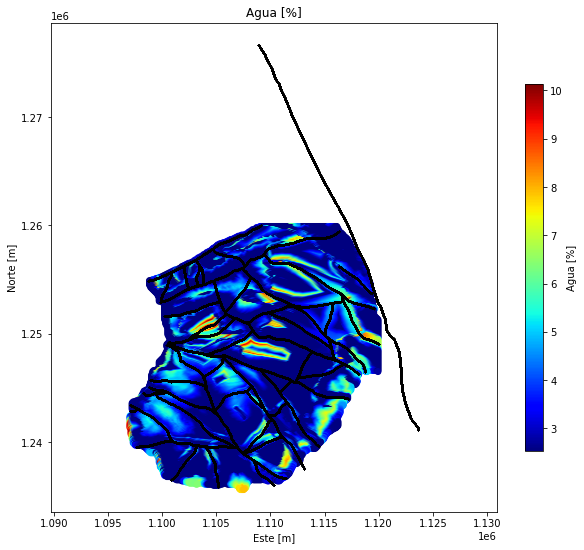

/n


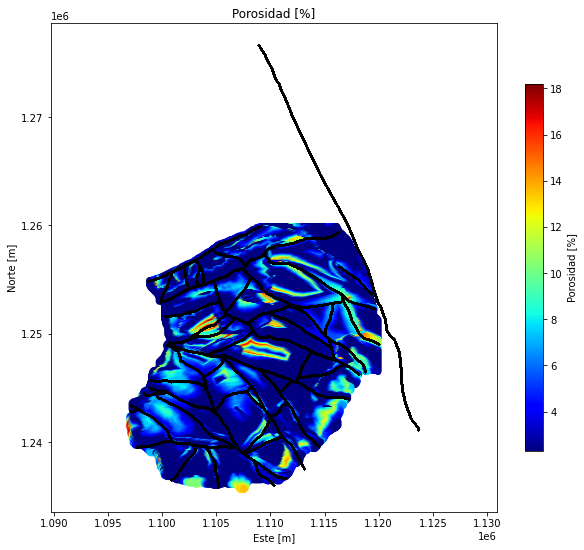

/n


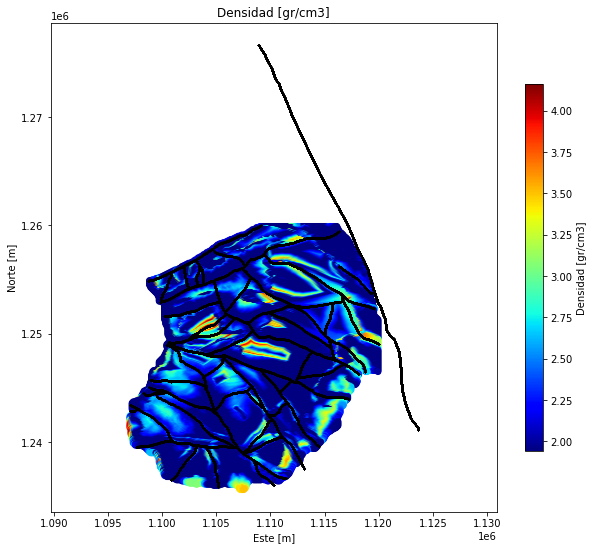

/n


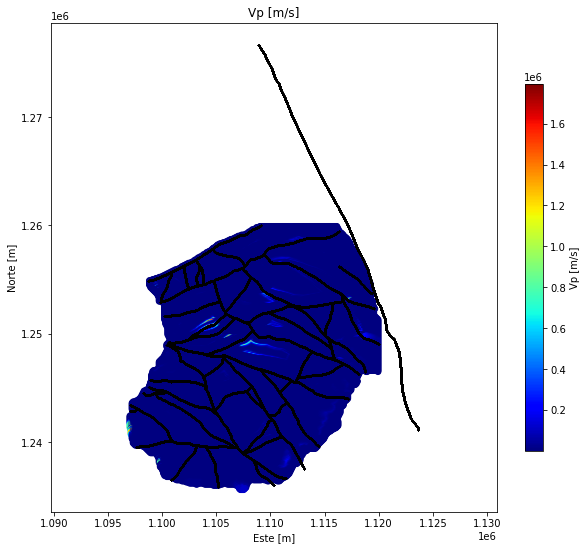

/n


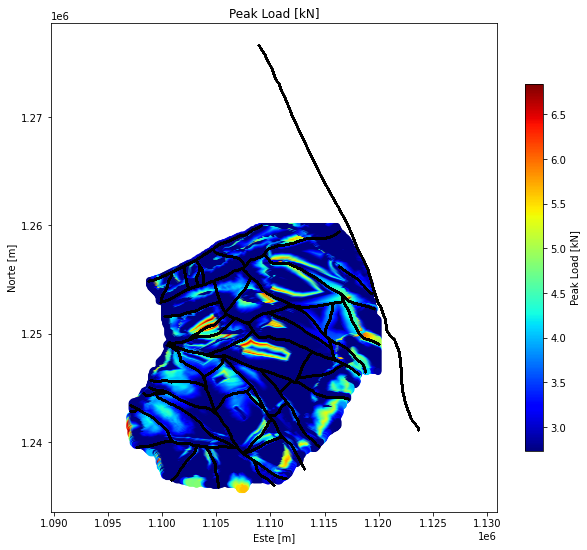

/n


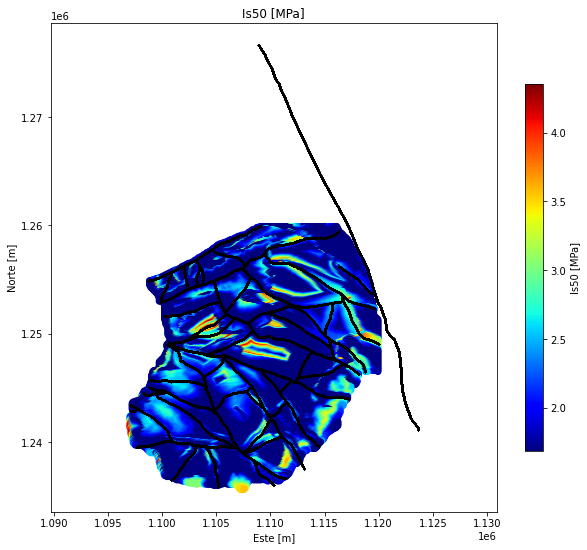

/n


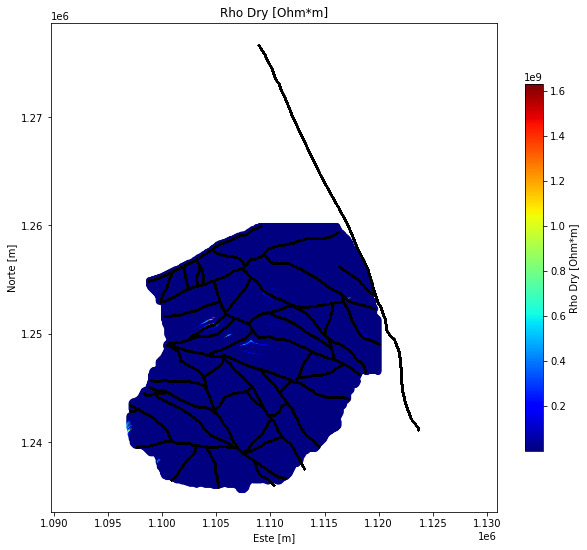

/n


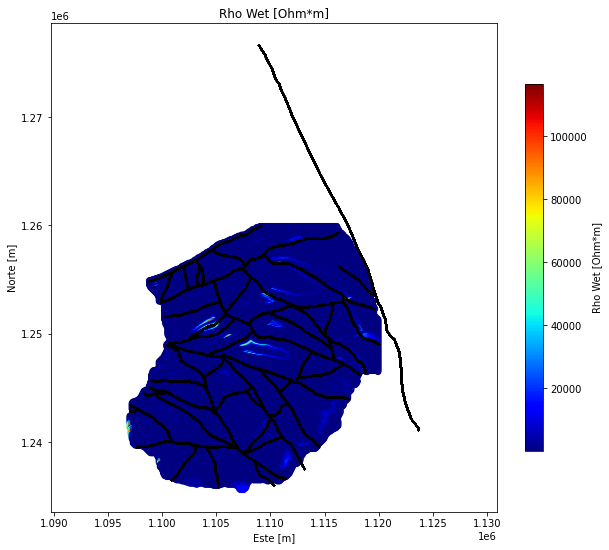

/n


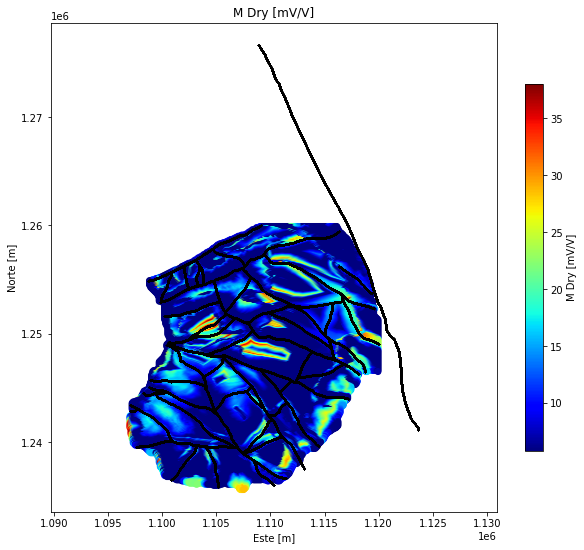

/n


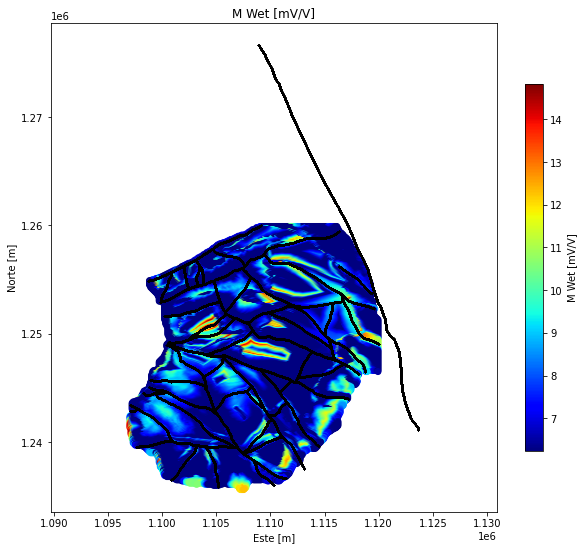

/n


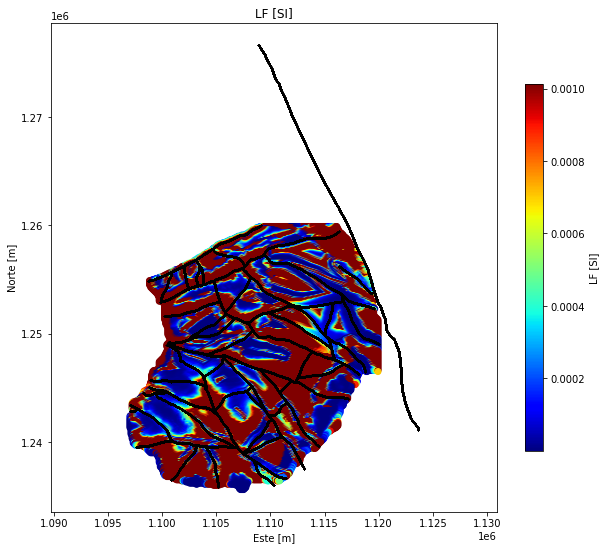

/n


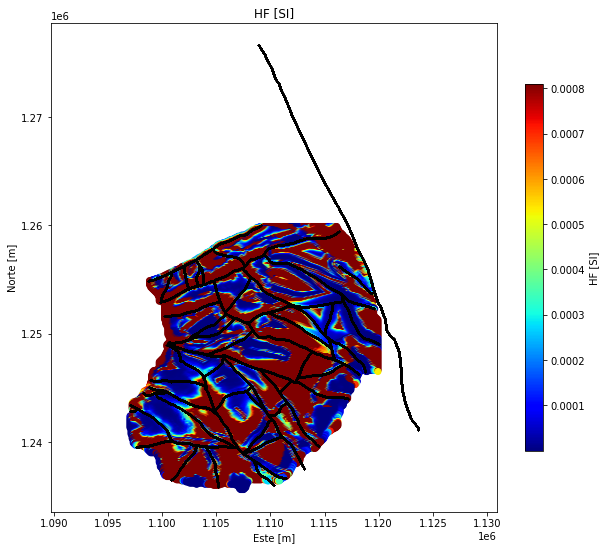

/n


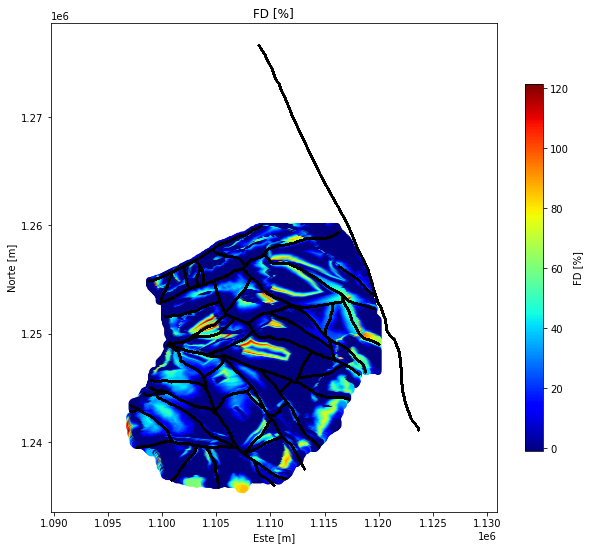

/n


In [ ]:
for i in ['Agua [%]', 'Porosidad [%]',  'Densidad [gr/cm3]',
          'Vp [m/s]', 'Peak Load [kN]', 'Is50 [MPa]',
          'Rho Dry [Ohm*m]', 'Rho Wet [Ohm*m]',
          'M Dry [mV/V]', 'M Wet [mV/V]',
          'LF [SI]', 'HF [SI]', 'FD [%]']:

  #plot 2D
  plt.figure(figsize=(10,9))
  plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
              c=MapaPrede[i], cmap='jet')#,
              #norm=colors.LogNorm(vmin=10**0, vmax=10**7))
  plt.xlabel('Este [m]')
  plt.ylabel('Norte [m]')
  plt.axis('equal')
  plt.title(i)
  plt.colorbar(shrink=0.75, label=i)
  plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
  plt.show()
  print('/n')


##Boxplot

In [ ]:
MapaPrede.describe()

In [ ]:
savePlots = False

#limites de las Graficas
lim_Agua = (-1, 33)
lim_Porosidad = (-1, 33)
lim_Densidad = (1.65, 3.45)
lim_RhoDry = (10**0, 10**7)
lim_RhoWet = (10**0, 10**7)
lim_MDry = (10**0, 10**3)
lim_MWet = (10**0, 10**3)
lim_Vp = (0, 8000)
lim_PeakLoad = (-1, 30)
lim_Is50 = (-1, 20)
lim_LF = (-1, 1e-1)
lim_HF = (-1, 1e-1)
lim_FD = (-3000, 20000)
lim_DistanciaFalla = (-100, 1700)

#propiedaes a graficar
propiedadesPlugs = ['Agua [%]',
                    'Porosidad [%]',
                    'Densidad [gr/cm3]',
                    'Rho Dry [Ohm*m]',
                    'Rho Wet [Ohm*m]',
                    'M Dry [mV/V]',
                    'M Wet [mV/V]',
                    'Vp [m/s]',
                    'Peak Load [kN]',
                    'Is50 [MPa]',
                    'LF [SI]',
                    'HF [SI]',
                    'FD [%]']#,
                    #'Distancia Falla [m]']

#Lista valores unicos
litos_u = plugs['Litologia'].unique() #litologias unicas
unidas_u = plugs['Unidad'].unique() #unidades unicas

#orden boxplots
ordenUnidades = ['Oss', 'J1gp', 'J1-2j', 'K1ls_mi', 'K1ls_mm', 'K1ls_ms', 'K1r', 'K1p', 'K1t']
ordenLitologias = ['esquisto', 'metaarenisca','granito', 'lodolita',
                   'arenisca','conglomerado', 'lodo calcareo',
                   'arenisca calcarea', 'biomicrita', 'caliza']

colores_lito = {'arenisca': 'yellow',
                'lodolita': 'goldenrod',
                'conglomerado': 'orange',
                'lodo calcareo': 'teal',
                'caliza': 'blue',
                'biomicrita': 'cyan',
                'arenisca calcarea': 'springgreen',
                'granito': 'red',
                'metaarenisca': 'green',
                'esquisto': 'lime'}


ordenUniLito = ['Oss [Es]', 'Oss [Ma]', 'J1gp [Gr]',
                'J1-2j [Ld]', 'K1ls_mm [Ld]', 'J1-2j [Ar]', 'K1ls_mi [Ar]',
                'K1ls_ms [Ar]', 'K1r [Ar]', 'J1-2j [Cg]', 'K1ls_mi [Cg]',
                'K1r [Lc]', 'K1p [Lc]', 'K1r [Ac]', 'K1p [Ac]',
                'K1r [Bm]', 'K1p [Bm]', 'K1t [Bm]', 'K1r [Ca]', 'K1p [Ca]']

colores_UniLito = {'Oss [Es]': 'lime',
                   'Oss [Ma]': 'green',
                   'J1gp [Gr]': 'red',
                   'J1-2j [Ld]': 'goldenrod',
                   'K1ls_mm [Ld]': 'goldenrod',
                   'J1-2j [Ar]': 'yellow',
                   'K1ls_mi [Ar]': 'yellow',
                   'K1ls_ms [Ar]': 'yellow',
                   'K1r [Ar]': 'yellow',
                   'J1-2j [Cg]': 'orange',
                   'K1ls_mi [Cg]': 'orange',
                   'K1r [Lc]': 'teal',
                   'K1p [Lc]': 'teal',
                   'K1r [Ac]': 'springgreen',
                   'K1p [Ac]': 'springgreen',
                   'K1r [Bm]': 'cyan',
                   'K1p [Bm]': 'cyan',
                   'K1t [Bm]': 'cyan',
                   'K1r [Ca]': 'blue',
                   'K1p [Ca]': 'blue'}

#genero color por unidad para los simbolos
colores_unidad = {'Oss':'tab:purple', #silgara
                  'J1gp':'tab:pink', #granito
                  'J1-2j':'tab:cyan', #jordan
                  'K1ls_mi':'tab:green', #santos inf
                  'K1ls_mm':'lime', #santos med
                  'K1ls_ms':'yellow', #santo sup
                  'K1r':'tab:brown', #rosablanca
                  'K1p':'tab:olive', #paja
                  'K1t':'tab:orange'} #tablazo


#genero un simbolo por litologia
simbolo_lito = {'arenisca': 'o',
                'lodolita': 'v',
                'conglomerado': 'X',
                'lodo calcareo': '^',
                'caliza': 'D',
                'biomicrita': 'd',
                'arenisca calcarea': 's',
                'granito': 'P',
                'metaarenisca': '>',
                'esquisto': '<'}

plugs['Color'] = plugs['Unidad'].replace(colores_unidad)
plugs['Simbolo'] = plugs['Litologia'].replace(simbolo_lito)

#Configuracion de la leyenda
simbol_unicos = plugs['Simbolo'].unique() #simbolos unicos a usar

custom_lines = [Line2D([0], [0], color='tab:orange', lw=6),
                Line2D([0], [0], color='tab:olive', lw=6),
                Line2D([0], [0], color='tab:brown', lw=6),
                Line2D([0], [0], color='yellow', lw=6),
                Line2D([0], [0], color='lime', lw=6),
                Line2D([0], [0], color='tab:green', lw=6),
                Line2D([0], [0], color='tab:cyan', lw=6),
                Line2D([0], [0], color='tab:pink', lw=6),
                Line2D([0], [0], color='tab:purple', lw=6)]
labels_unidad = ['K1t', 'K1p', 'K1r', 'K1ls_ms', 'K1ls_mm', 'K1ls_mi', 'J1-2j', 'J1gp','OSs']

custom_simbol = [Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='v', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='X', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='D', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='d', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='s', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='P', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='>', color='w', markerfacecolor='k', markersize=8),
                Line2D([0], [0], marker='<', color='w', markerfacecolor='k', markersize=8)]
labels_simbol = ['arenisca',
                 'lodolita',
                 'conglomerado',
                 'lodo calcareo',
                 'caliza',
                 'biomicrita',
                 'arenisca calcarea',
                 'granito',
                 'metaarenisca',
                 'esquisto']

#plugs.head()

In [ ]:
#boxplots por Unidad

for i in propiedadesPlugs:
  plt.figure(figsize=(14,5))
  ax = sn.boxplot(x='Unidad', y=i, data=MapaPrede,
                  palette = colores_unidad,
                  order=ordenUnidades)
  ax = sn.swarmplot(x='Unidad', y=i,  data=plugs, color='r', size=4.0,
                    order=ordenUnidades)
  plt.ylabel(('{}').format(i))
  '''
  if i == 'Agua [%]':
    plt.ylim(lim_Agua)
  if i == 'Porosidad [%]':
    plt.ylim(lim_Porosidad)
  if i == 'Densidad [gr/cm3]':
    plt.ylim(lim_Densidad)
  '''
  if i == 'Rho Dry [Ohm*m]':
    plt.yscale('log')
    #plt.ylim(lim_RhoDry)
  if i == 'Rho Wet [Ohm*m]':
    plt.yscale('log')
    #plt.ylim(lim_RhoWet)
  if i == 'M Dry [mV/V]':
    plt.yscale('log')
    #plt.ylim(lim_MDry)
  if i =='M Wet [mV/V]':
    plt.yscale('log')
    #plt.ylim(lim_MWet)
  '''
  if i =='Vp [m/s]':
    plt.ylim(lim_Vp)
  if i == 'Peak Load [kN]':
    plt.ylim(lim_PeakLoad)
  if i == 'Is50 [MPa]':
    plt.ylim(lim_Is50)
  '''
  if i == 'LF [SI]':
    plt.yscale('log')
    #plt.ylim(lim_LF)
  if i == 'HF [SI]':
    plt.yscale('log')
    #plt.ylim(lim_HF)
  '''
  if i == 'FD [%]':
    plt.ylim(lim_FD)
  if i == 'Distancia Falla [m]':
    plt.ylim(lim_DistanciaFalla)
  '''
  print('\n')
  if savePlots == True:
    plt.savefig(('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxUnidades_{}.png').format(i),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

  plt.show()

#Propiedades

In [ ]:
#orden boxplots
ordenUnidades = ['Oss', 'J1gp', 'J1-2j', 'K1ls_mi', 'K1ls_mm', 'K1ls_ms', 'K1r', 'K1p', 'K1t']

#genero color por unidad para los simbolos
colores_unidad = {'Oss':'tab:purple', #silgara
                  'J1gp':'tab:pink', #granito
                  'J1-2j':'tab:cyan', #jordan
                  'K1ls_mi':'tab:green', #santos inf
                  'K1ls_mm':'lime', #santos med
                  'K1ls_ms':'yellow', #santo sup
                  'K1r':'tab:brown', #rosablanca
                  'K1p':'tab:olive', #paja
                  'K1t':'tab:orange'} #tablazo



In [ ]:
X

Xn        Yn        Zn       DFn  GeoNN
0    0.779888  0.436505  0.957071  0.526410      5
1    0.817065  0.468702  0.965152  0.192367      5
2    0.817065  0.468702  0.965152  0.192367      5
3    0.795913  0.866347  0.922727  0.007080      5
4    0.785311  0.882614  0.887879  0.070553      5
..        ...       ...       ...       ...    ...
353  0.426877  0.325632  0.883838  0.327637      5
354  0.426877  0.325632  0.883838  0.327637      5
355  0.492581  0.379576  0.917172  0.067080      5
356  0.493718  0.388534  0.928283  0.016133      5
357  0.540782  0.409367  0.935354  0.164123      5

[358 rows x 5 columns]

In [ ]:
y

Agua [%]  Porosidad [%]  ...  Log10 HF [SI]  FD [%]
0        6.39          10.98  ...         -4.623  -61.45
1        6.07           9.89  ...         -5.519   59.76
2        6.76           7.84  ...         -4.498  -49.71
3        4.07           7.24  ...         -5.780   50.98
4        0.68          20.17  ...         -4.439  -69.97
..        ...            ...  ...            ...     ...
353      2.99           0.21  ...         -5.889   38.44
354      3.70           2.51  ...         -5.353   38.95
355      9.15           0.32  ...         -5.130   10.79
356      5.10           0.90  ...         -5.321   -7.46
357      5.44           0.12  ...         -4.971  -88.46

[358 rows x 13 columns]

In [ ]:
dfMapaSup

coorX       coorY        coorZ  ...    Y_norm    Z_norm   Df_norm
0      1109036.77  1259898.34  1284.000000  ...  0.991802  0.724242  0.016287
1      1109136.77  1259898.34  1309.000000  ...  0.991802  0.736869  0.033217
2      1109236.77  1259898.34  1317.000000  ...  0.991802  0.740909  0.054497
3      1109336.77  1259898.34  1330.000000  ...  0.991802  0.747475  0.083537
4      1109436.77  1259898.34  1350.000000  ...  0.991802  0.757576  0.114930
...           ...         ...          ...  ...       ...       ...       ...
40820  1107636.77  1235698.34   441.028076  ...  0.008063  0.298499  0.236543
40821  1107236.77  1235598.34   441.000000  ...  0.003998  0.298485  0.289427
40822  1107336.77  1235598.34   442.000000  ...  0.003998  0.298990  0.320447
40823  1107436.77  1235598.34   439.137299  ...  0.003998  0.297544  0.301820
40824  1107536.77  1235598.34   442.000000  ...  0.003998  0.298990  0.282423

[40825 rows x 11 columns]

In [ ]:
dfMapaSup['Unidad2'] = dfMapaSup['Unidad'].replace({'OSs':'Oss'})
dfMapaSup['Unidad2'].unique()

array(['K1ls_mi', 'J1-2j', 'Oss', 'J1gp', 'K1ls_mm', 'K1ls_ms', 'K1r',
       'K1p', 'K1t'], dtype=object)

In [ ]:
mapaSupEntrada = dfMapaSup[['X_norm', 'Y_norm',	'Z_norm',	'Df_norm', 'codigoUnidad']]
mapaSupEntrada

X_norm    Y_norm    Z_norm   Df_norm  codigoUnidad
0      0.527212  0.991802  0.724242  0.016258             3
1      0.531486  0.991802  0.736869  0.033200             3
2      0.535759  0.991802  0.740909  0.053828             3
3      0.540033  0.991802  0.747475  0.082428             3
4      0.544306  0.991802  0.757576  0.113634             3
...         ...       ...       ...       ...           ...
40820  0.467383  0.008063  0.298499  0.628693             2
40821  0.450289  0.003998  0.298485  0.696013             2
40822  0.454563  0.003998  0.298990  0.724802             2
40823  0.458836  0.003998  0.297544  0.699951             2
40824  0.463110  0.003998  0.298990  0.675826             2

[40825 rows x 5 columns]

##Agua

In [ ]:
yAgua = y['Agua [%]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yAgua, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Agua/aguaNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 105:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Agua/aguaNNrelu_hl15_7_5Sc51.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Agua/aguaNNrelu_hl15_7_5Sc51.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
dfMapaSup

coorX       coorY        coorZ  ...    Z_norm   Df_norm  Unidad2
0      1109036.77  1259898.34  1284.000000  ...  0.724242  0.016258  K1ls_mi
1      1109136.77  1259898.34  1309.000000  ...  0.736869  0.033200  K1ls_mi
2      1109236.77  1259898.34  1317.000000  ...  0.740909  0.053828  K1ls_mi
3      1109336.77  1259898.34  1330.000000  ...  0.747475  0.082428  K1ls_mi
4      1109436.77  1259898.34  1350.000000  ...  0.757576  0.113634  K1ls_mi
...           ...         ...          ...  ...       ...       ...      ...
40820  1107636.77  1235698.34   441.028076  ...  0.298499  0.628693    J1-2j
40821  1107236.77  1235598.34   441.000000  ...  0.298485  0.696013    J1-2j
40822  1107336.77  1235598.34   442.000000  ...  0.298990  0.724802    J1-2j
40823  1107436.77  1235598.34   439.137299  ...  0.297544  0.699951    J1-2j
40824  1107536.77  1235598.34   442.000000  ...  0.298990  0.675826    J1-2j

[40825 rows x 12 columns]

In [ ]:
dfMapaSup['Agua [%]'] = mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
mlr.loss_curve_

AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


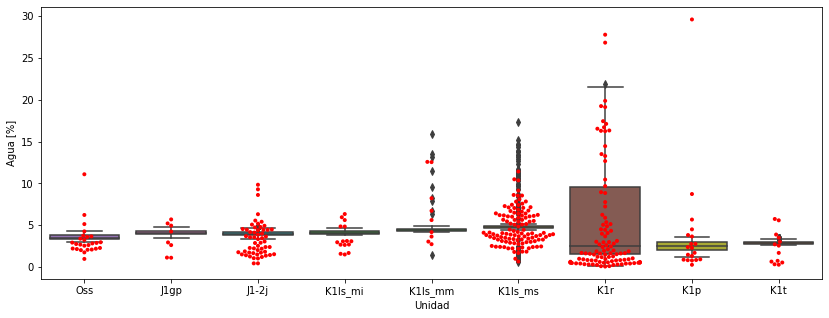

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Agua [%]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Agua [%]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('Agua [%]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNagua.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

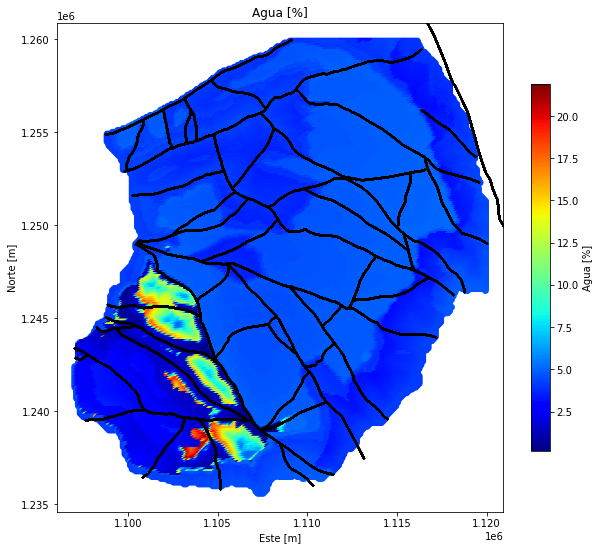

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Agua [%]'], cmap='jet')#,
            #norm=colors.LogNorm(vmin=10**0, vmax=10**7))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Agua [%]')
plt.colorbar(shrink=0.75, label='Agua [%]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##Porosidad

In [ ]:
yPorosidad = y['Porosidad [%]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yPorosidad, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Porosidad/porosidadNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 105:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#porosidadNNtanh_hl20_8_5Sc73
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Porosidad/porosidadNNrelu_hl25_8_5Sc32.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Porosidad/porosidadNNrelu_hl25_8_5Sc32.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
dfMapaSup['Porosidad [%]'] = mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


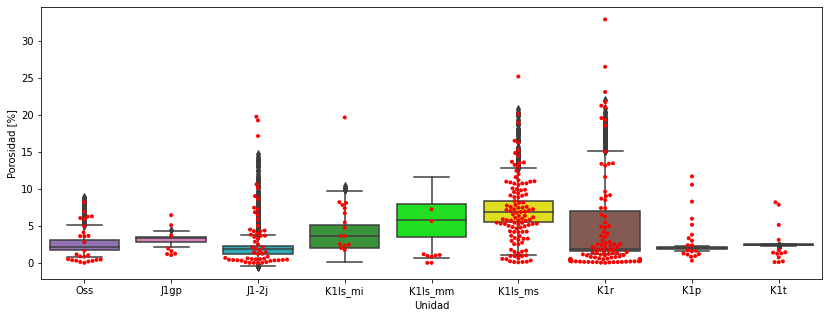

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Porosidad [%]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Porosidad [%]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('Porosidad [%]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNporosidad.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
#plt.savefig('porosidadNNrelu_hl5_5_5Sc45.png',
#            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

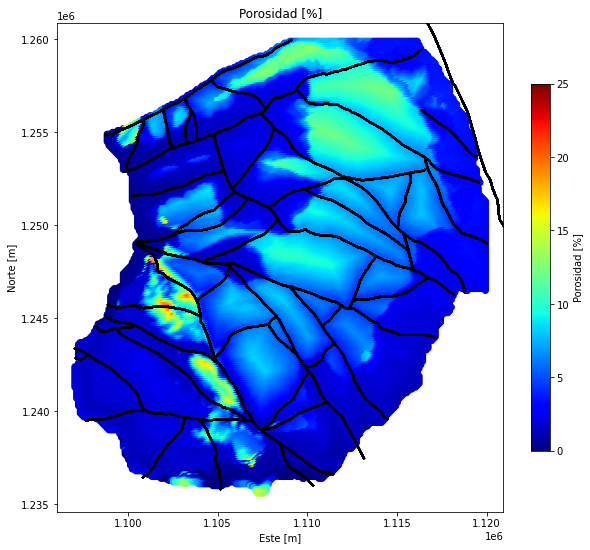

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Porosidad [%]'], cmap='jet')#,
             # vmin=0, vmax=25)#,
            #norm=colors.LogNorm(vmin=10**0, vmax=10**7))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Porosidad [%]')
plt.colorbar(shrink=0.75, label='Porosidad [%]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)

#plt.savefig('mapa_porosidadNNrelu_hl25_8_5Sc32.png',
#            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

##Densidad

In [ ]:
yDensidad = y['Densidad [gr/cm3]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yDensidad, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Densidad/densidadNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 105:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Densidad/densidadNNrelu_hl35_11_5Sc45.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Densidad/densidadNNrelu_hl35_11_5Sc45.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
dfMapaSup['Densidad [gr/cm3]'] = mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 38.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


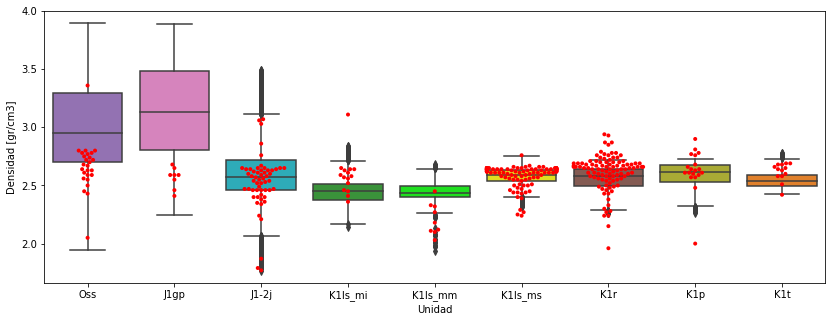

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Densidad [gr/cm3]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Densidad [gr/cm3]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('Densidad [gr/cm3]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNdensidad.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

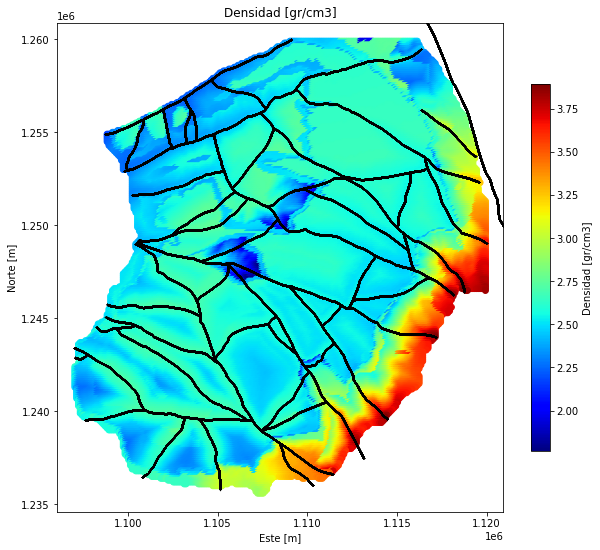

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Densidad [gr/cm3]'], cmap='jet')#,
            #norm=colors.LogNorm(vmin=10**0, vmax=10**7))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Densidad [gr/cm3]')
plt.colorbar(shrink=0.75, label='Densidad [gr/cm3]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##RhoDry

In [ ]:
#esta es calculada por ledio del log10
yRhoDry = y['Log10 Rho Dry [Ohm*m]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yRhoDry, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [25,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/RhoDry/rhoDryNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 0
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[1] == 26:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#rhoDryNNrelu_hl25_5_5Sc44
#rhoDryNNtanh_hl15_7_5Sc84 #para comparar
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/RhoDry/rhoDryNNrelu_hl25_9_5Sc53.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/RhoDry/rhoDryNNrelu_hl25_9_5Sc53.pkl')

In [ ]:
#se reescalan a 10**y
dfMapaSup['Rho Dry [Ohm*m]'] = 10 ** mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 34.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 69.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; y

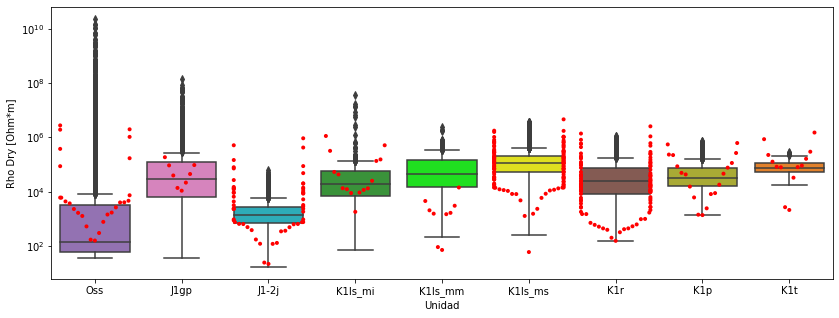

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Rho Dry [Ohm*m]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Rho Dry [Ohm*m]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.yscale('log')
plt.ylabel('Rho Dry [Ohm*m]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNrhoDry.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

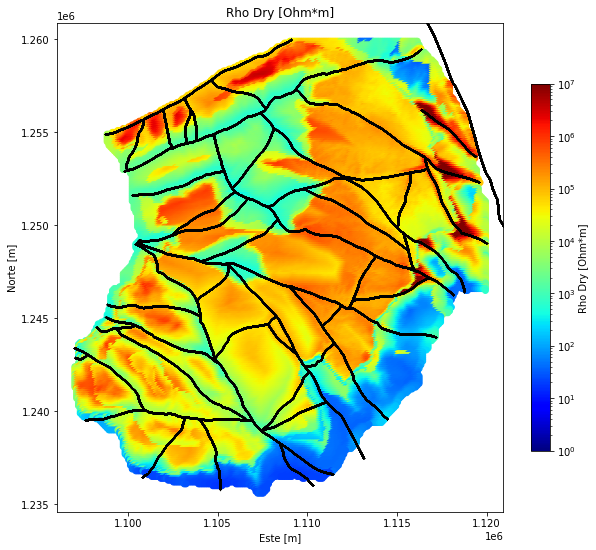

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Rho Dry [Ohm*m]'], cmap='jet',
            norm=colors.LogNorm(vmin=10**0, vmax=10**7))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Rho Dry [Ohm*m]')
plt.colorbar(shrink=0.75, label='Rho Dry [Ohm*m]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##RhoWet

In [ ]:
#esta es calculada por ledio del log10
yRhoWet = y['Log10 Rho Wet [Ohm*m]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yRhoWet, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/RhoWet/rhoWetNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 105:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#rhoWetNNrelu_hl45_13_5Sc46
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/RhoWet/rhoWetNNrelu_hl10_6_5Sc33.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/RhoWet/rhoWetNNrelu_hl10_6_5Sc33.pkl')

In [ ]:
#se reescalan a 10**y
dfMapaSup['Rho Wet [Ohm*m]'] = 10 ** mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 75.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 47.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


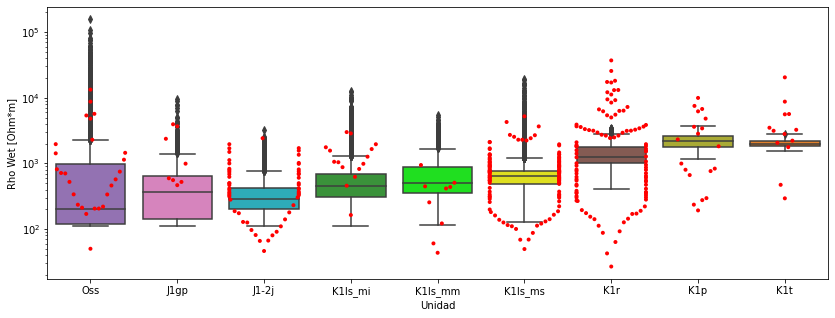

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Rho Wet [Ohm*m]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Rho Wet [Ohm*m]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.yscale('log')
plt.ylabel('Rho Wet [Ohm*m]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNrhoWet.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

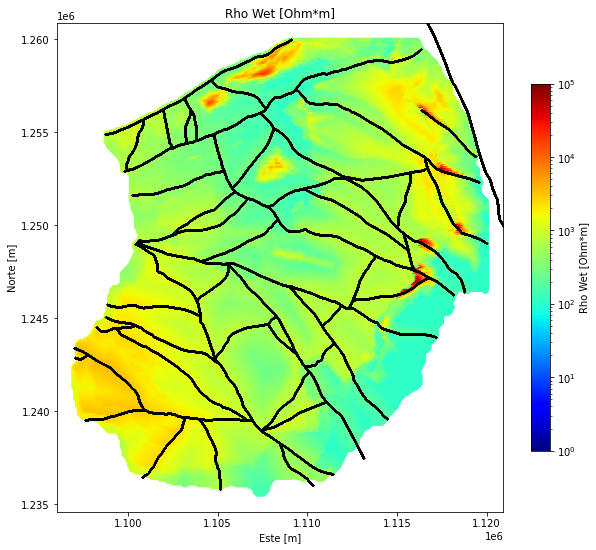

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Rho Wet [Ohm*m]'], cmap='jet',
            norm=colors.LogNorm(vmin=10**0, vmax=10**5))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Rho Wet [Ohm*m]')
plt.colorbar(shrink=0.75, label='Rho Wet [Ohm*m]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##MDry

In [ ]:
yMdry = y['M Dry [mV/V]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yMdry, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/MDry/mDryNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 105:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/MDry/mDryNNrelu_hl5_5_5Sc31.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/MDry/mDryNNrelu_hl5_5_5Sc31.pkl')

In [ ]:
dfMapaSup['M Dry [mV/V]'] = mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 65.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 64.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 61.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


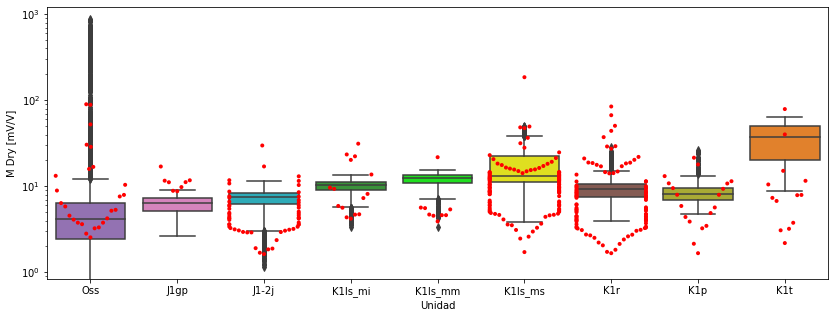

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='M Dry [mV/V]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='M Dry [mV/V]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('M Dry [mV/V]')
plt.yscale('log')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNmDry.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

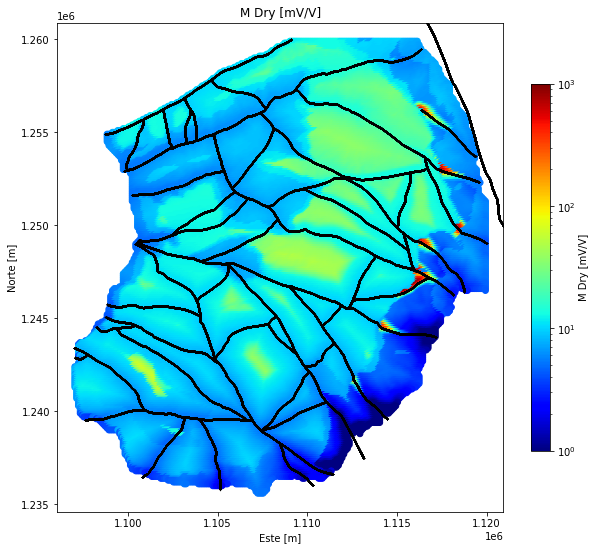

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['M Dry [mV/V]'], cmap='jet',
            norm=colors.LogNorm(vmin=10**0, vmax=10**3))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('M Dry [mV/V]')
plt.colorbar(shrink=0.75, label='M Dry [mV/V]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##MWet

In [ ]:
yMwet = y['M Wet [mV/V]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yMwet, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/MWet/mWetNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 105:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#mWetNNrelu_hl30_10_5Sc47
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/MWet/mWetNNrelu_hl15_5_5Sc40.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/MWet/mWetNNrelu_hl15_5_5Sc40.pkl')

In [ ]:
dfMapaSup['M Wet [mV/V]'] = mlr.predict(mapaSupEntrada)

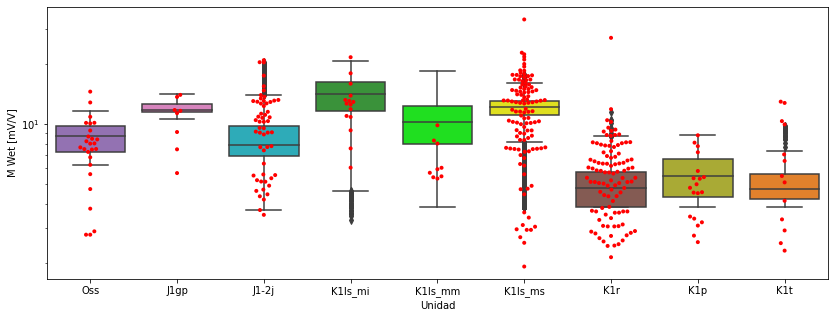

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='M Wet [mV/V]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='M Wet [mV/V]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('M Wet [mV/V]')
plt.yscale('log')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNmWet.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

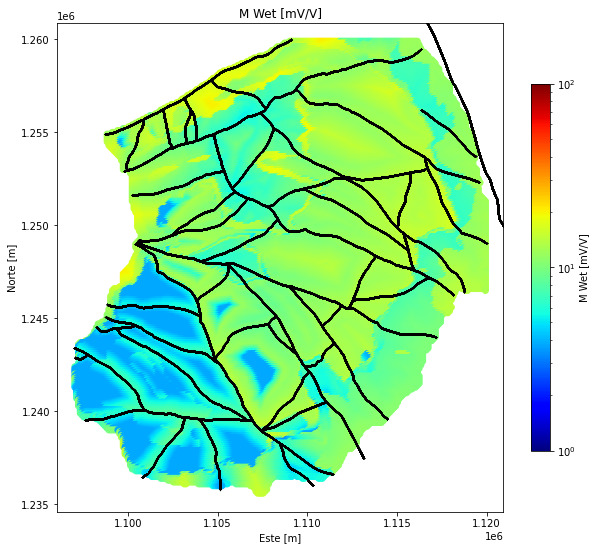

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['M Wet [mV/V]'], cmap='jet',
            norm=colors.LogNorm(vmin=10**0, vmax=10**2))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('M Wet [mV/V]')
plt.colorbar(shrink=0.75, label='M Wet [mV/V]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##Vp

In [ ]:
yVp = y['Log10 Vp [m/s]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yVp, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Vp/vpNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 55:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#vpNNrelu_hl15_13_5Sc41
#vpNNlogistic_hl5_5_5Sc35
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Vp/vpNNrelu_hl15_13_5Sc41.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Vp/vpNNrelu_hl15_13_5Sc41.pkl')

In [ ]:
#se Normalizan los datos
dfMapaSup['Vp [m/s]'] = 10 ** mlr.predict(mapaSupEntrada)

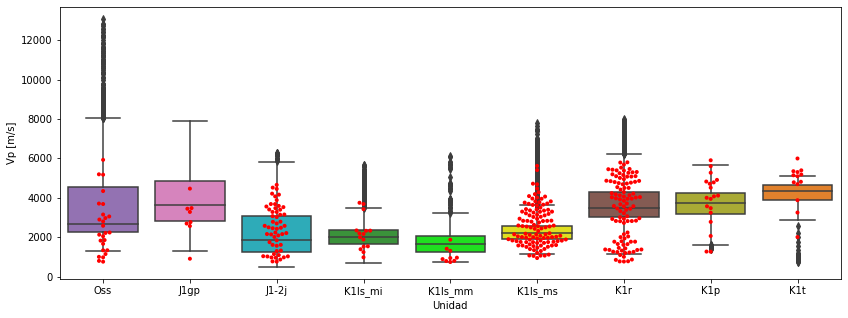

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Vp [m/s]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Vp [m/s]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('Vp [m/s]')
#plt.yscale('log')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNvp.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

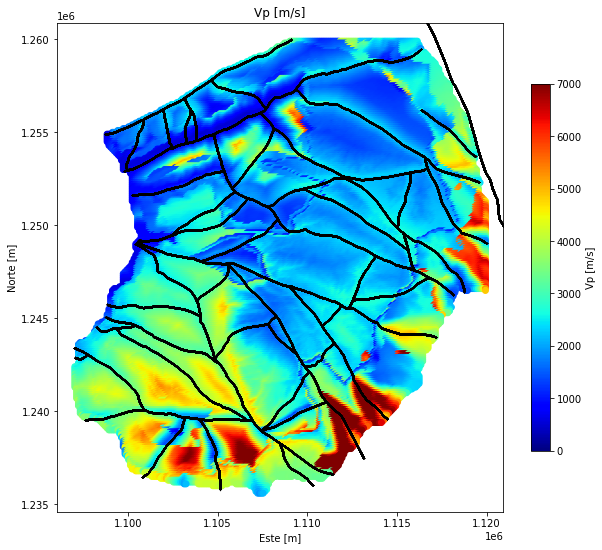

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Vp [m/s]'], cmap='jet',vmin=0, vmax=7000)#,
            #norm=colors.LogNorm(vmin=10**0, vmax=10**2))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Vp [m/s]')
plt.colorbar(shrink=0.75, label='Vp [m/s]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##PeakLoad

In [ ]:
yPeakLoad = y['Peak Load [kN]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yPeakLoad, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [15,5,5]
actFun = 'relu' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/PeakLoad/peakLoadNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 0
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[1] == 16:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#peakLoadNNrelu_hl15_5_5Sc37
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/PeakLoad/peakLoadNNrelu_hl15_5_5Sc37.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/PeakLoad/peakLoadNNrelu_hl15_5_5Sc37.pkl')

In [ ]:
dfMapaSup['Peak Load [kN]'] = mlr.predict(mapaSupEntrada)

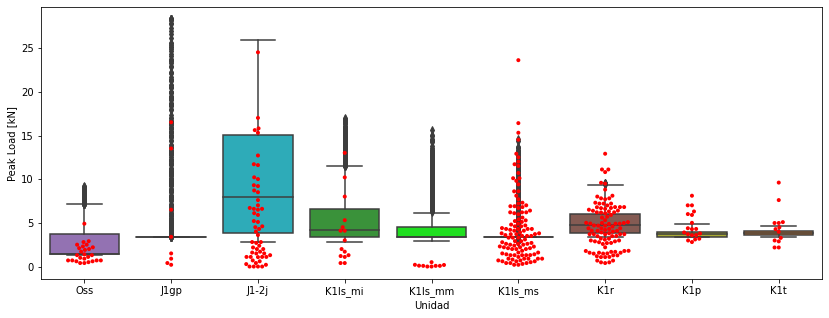

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Peak Load [kN]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Peak Load [kN]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('Peak Load [kN]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNpeakLoad.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

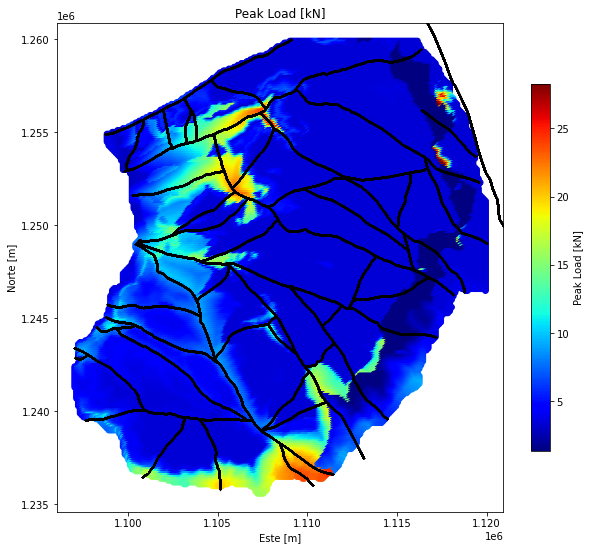

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Peak Load [kN]'], cmap='jet')#,
            #norm=colors.LogNorm(vmin=10**0, vmax=10**7))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Peak Load [kN]')
plt.colorbar(shrink=0.75, label='Peak Load [kN]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##Is50

In [ ]:
yIs50 = y['Is50 [MPa]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yIs50, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Is50/is50NN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 105:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#is50NNrelu_hl20_6_5Sc36
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Is50/is50NNrelu_hl20_6_5Sc36.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Is50/is50NNrelu_hl20_6_5Sc36.pkl')

In [ ]:
dfMapaSup['Is50 [MPa]'] = mlr.predict(mapaSupEntrada)

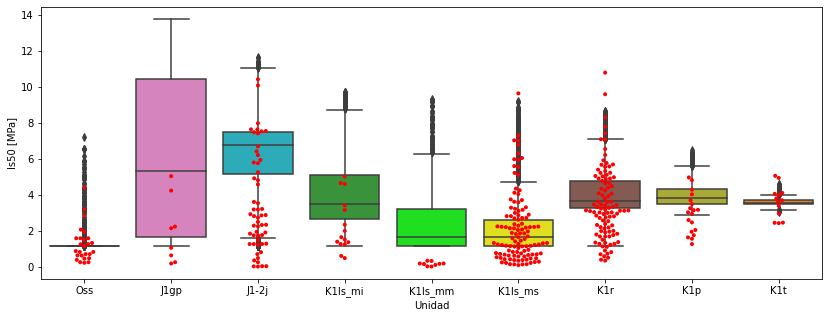

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='Is50 [MPa]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='Is50 [MPa]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('Is50 [MPa]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNis50.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

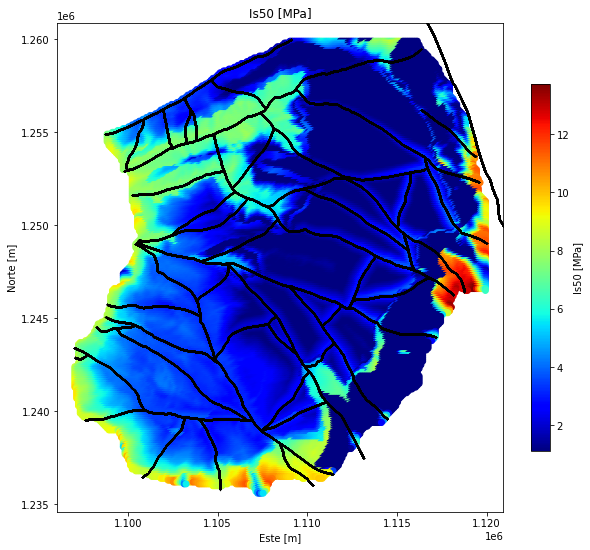

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['Is50 [MPa]'], cmap='jet')#,
            #norm=colors.LogNorm(vmin=10**0, vmax=10**7))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('Is50 [MPa]')
plt.colorbar(shrink=0.75, label='Is50 [MPa]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##Lf

In [ ]:
#esta es calculada por ledio del log10
yLf = y['Log10 LF [SI]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yLf, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Lf/lfNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 55:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#lfNNrelu_hl5_5_5Sc57
#lfNNrelu_hl10_6_5Sc59
#lfNNrelu_hl5_5_5Sc56
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Lf/lfNNrelu_hl10_6_5Sc61.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Lf/lfNNrelu_hl10_6_5Sc61.pkl')

In [ ]:
#se reescalan a 10**y
dfMapaSup['LF [SI]'] = 10 ** mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 69.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


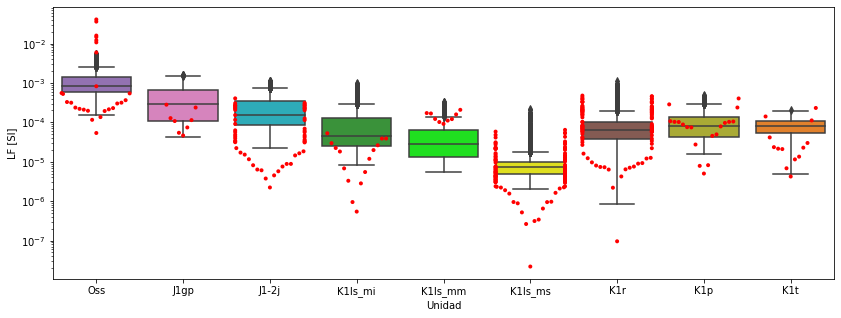

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='LF [SI]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='LF [SI]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.yscale('log')
plt.ylabel('LF [SI]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNlf.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

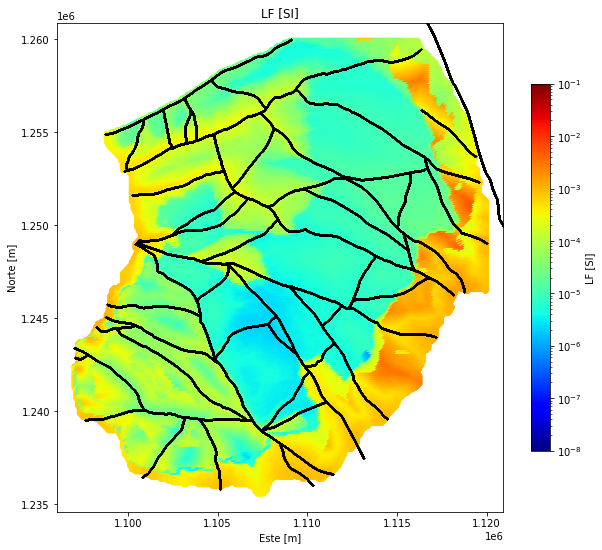

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['LF [SI]'], cmap='jet',
            norm=colors.LogNorm(vmin=10**-8, vmax=10**-1))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('LF [SI]')
plt.colorbar(shrink=0.75, label='LF [SI]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##Hf

In [ ]:
#esta es calculada por ledio del log10
yHf = y['Log10 HF [SI]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yHf, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Hf/hfNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 55:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Hf/hfNNrelu_hl30_10_5Sc65.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Hf/hfNNrelu_hl30_10_5Sc65.pkl')

In [ ]:
#se reescalan a 10**y
dfMapaSup['HF [SI]'] = 10 ** mlr.predict(mapaSupEntrada)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 69.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


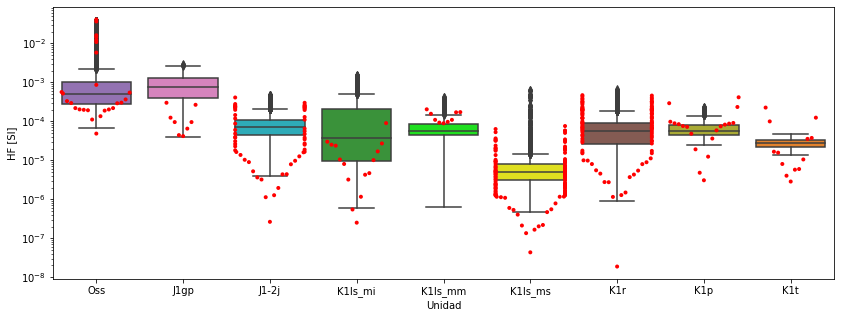

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='HF [SI]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='HF [SI]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.yscale('log')
plt.ylabel('HF [SI]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNhf.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

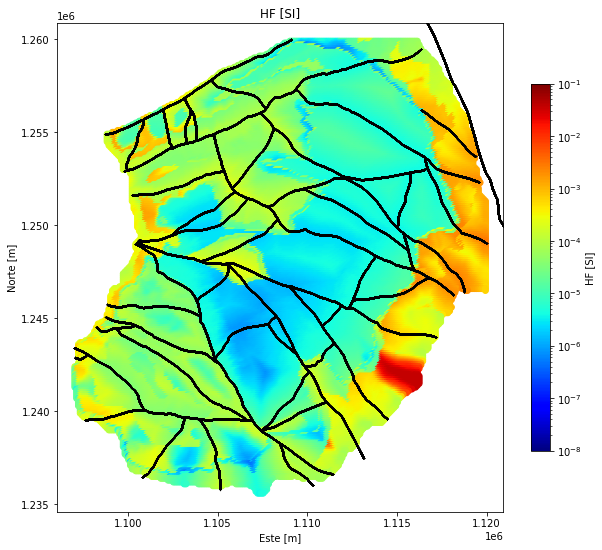

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['HF [SI]'], cmap='jet',
            norm=colors.LogNorm(vmin=10**-8, vmax=10**-1))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('HF [SI]')
plt.colorbar(shrink=0.75, label='HF [SI]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

##FD

In [ ]:
yFd = y['FD [%]'].copy()


In [ ]:
#se separan los datos
X_train, X_test, y_train, y_test = train_test_split(X, yFd, test_size=0.2,
                                                    train_size=0.8, random_state=0)

In [ ]:
capasOcuptas = [5,5,5]
actFun = 'logistic' # tanh relu logistic
scoreInferior = 30
while True:
  for i in range(5):
    print("Capas ocultas: ", capasOcuptas, "ciclo= ", i+1)
    #se crea la red
    mlr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=tuple(capasOcuptas),  #(30,30,20),
                      activation=actFun, #tanh relu logistic
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True,
                      max_iter=6000)
    #se entrena la red
    mlr.fit(X_train, y_train)

    #score
    scoreRed = mlr.score(X_train, y_train)
    print(scoreRed)
    scoreRed2 = int(100 * scoreRed)

    if scoreRed2 > scoreInferior:
      scoreInferior = scoreRed2
      joblib.dump(mlr, ('/content/drive/MyDrive/LosSantos/NNplugs/Fd/fdNN{}_hl{}_{}_{}Sc{}.pkl').format(actFun,capasOcuptas[0], capasOcuptas[1], capasOcuptas[2], scoreRed2))

  #se aumenta el numero de neuronas
  capasOcuptas[0] += 5
  capasOcuptas[1] += 1
  capasOcuptas[2] += 0

  #para detener cuando primera capa tenga 100
  if capasOcuptas[0] == 55:
    print('Listo')
    break
  if scoreInferior > 80:
    print('Listo')
    break
#se predice
pred1 = mlr.predict(mapaSupEntrada)


###Boxplots

In [ ]:
#se carga la red de interes
#mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Fd/fdNNlogistic_hl70_18_5Sc39.pkl')
mlr = joblib.load('/content/drive/MyDrive/LosSantos/NNplugs/Fd/fdNNlogistic_hl70_18_5Sc39.pkl')

In [ ]:
dfMapaSup['FD [%]'] = mlr.predict(mapaSupEntrada)

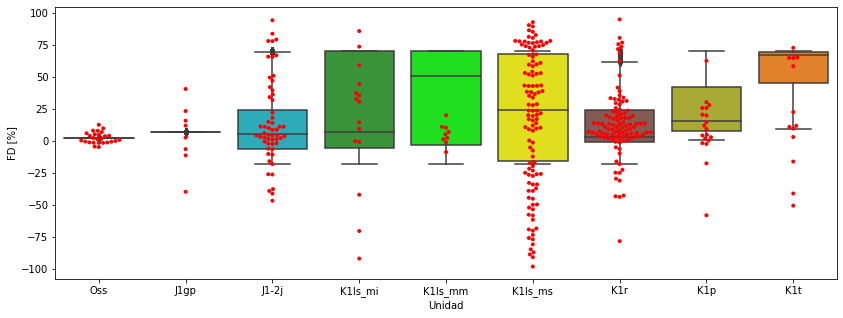

In [ ]:
plt.figure(figsize=(14,5))
ax = sn.boxplot(x='Unidad2', y='FD [%]', data=dfMapaSup,
                palette = colores_unidad,
                order=ordenUnidades)
ax = sn.swarmplot(x='Unidad', y='FD [%]',  data=plugs, color='r', size=4.0,
                  order=ordenUnidades)
plt.ylabel('FD [%]')
plt.savefig('/content/drive/MyDrive/LosSantos/GraficasNuevas/BoxNNfd.png',
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)
plt.show()

###Mapas

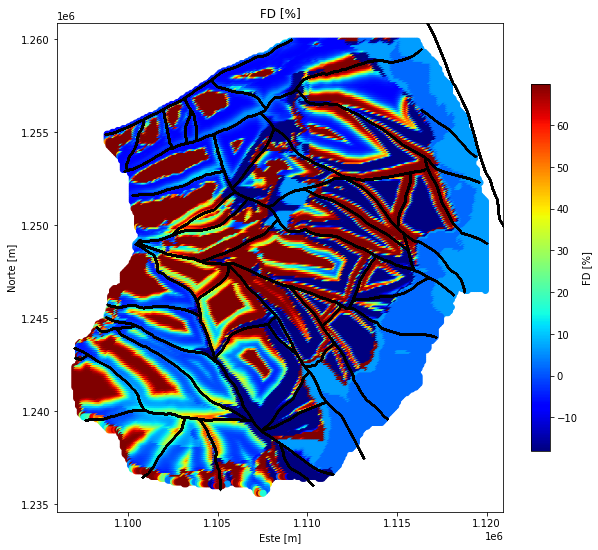

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(dfMapaSup['coorX'], dfMapaSup['coorY'],
            c=dfMapaSup['FD [%]'], cmap='jet')#,
            #norm=colors.LogNorm(vmin=10**0, vmax=10**7))
plt.xlim(dfMapaSup['coorX'].min() - 1000, dfMapaSup['coorX'].max() + 1000)
plt.ylim(dfMapaSup['coorY'].min() - 1000, dfMapaSup['coorY'].max() + 1000)
plt.xlabel('Este [m]')
plt.ylabel('Norte [m]')
#plt.axis('equal')
plt.title('FD [%]')
plt.colorbar(shrink=0.75, label='FD [%]')
plt.scatter(df_PuntosFallas['CoorX'], df_PuntosFallas['CoorY'], c='k', s=0.1)
plt.show()

#Tabla final

In [ ]:
dfMapaSup.head()

coorX       coorY   coorZ  ...   LF [SI]   HF [SI]     FD [%]
0  1109036.77  1259898.34  1284.0  ...  0.000019  0.000019  10.313883
1  1109136.77  1259898.34  1309.0  ...  0.000017  0.000016   6.185676
2  1109236.77  1259898.34  1317.0  ...  0.000017  0.000014   2.256635
3  1109336.77  1259898.34  1330.0  ...  0.000016  0.000012  -1.471994
4  1109436.77  1259898.34  1350.0  ...  0.000015  0.000010  -3.881773

[5 rows x 25 columns]

In [ ]:
dfMapaSup['FD2 [%]'] = 100 * ((dfMapaSup['LF [SI]'] - dfMapaSup['HF [SI]']) / dfMapaSup['LF [SI]'])
dfMapaSup['FD2 [%]'].describe()

count    40825.000000
mean        -7.382889
std        149.562203
min      -2221.039160
25%         -9.340160
50%         34.044815
75%         60.338760
max         99.590128
Name: FD2 [%], dtype: float64

In [ ]:
#guardar tabla
#dfMapaSup.to_csv('/content/drive/MyDrive/LosSantos/tablaNNplugsFinal.csv', sep=',', decimal='.')

#considerando las nuevas fallas del profe
dfMapaSup.to_csv('/content/drive/MyDrive/LosSantos/tablaNNplugsFinal2.csv', sep=',', decimal='.')